In [49]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import geopandas as gpd

import cartopy.crs as ccrs
import scipy.stats as stats
import cartopy.feature as cfeature

import shapely.vectorized as sv

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from matplotlib.colors import BoundaryNorm

import shapely.geometry as sg
from shapely.geometry import Point

from sklearn.linear_model import LinearRegression

import sys
sys.path.append(os.path.abspath(".."))
from function import DOWN_raw
from function import ART_preprocessing as ART_pre

from playsound import playsound

import warnings
warnings.filterwarnings('ignore')

In [92]:
# Stations with problems
list_remove = [
            'IT-820_1424_FTS_1440_QCv4.csv', 'IT-250_602781_FTS_1440_QCv4.csv', 
            'IT-250_602779_FTS_1440_QCv4.csv', 'IT-780_2370_FTS_1440_QCv4.csv', 
            'IT-750_450_FTS_1440_QCv4.csv', 'IT-520_TOS11000099_FTS_1440_QCv4.csv',
            'IT-520_TOS11000080_FTS_1440_QCv4.csv', 'IT-520_TOS11000072_FTS_1440_QCv4.csv',
            'IT-520_TOS11000060_FTS_1440_QCv4.csv', 'IT-520_TOS11000025_FTS_1440_QCv4.csv',
            'IT-520_TOS09001200_FTS_1440_QCv4.csv', 'IT-520_TOS02000237_FTS_1440_QCv4.csv',
            'IT-230_1200_FTS_1440_QCv4.csv'
            ]

In [ ]:
def get_relative_error_list_individual(product, seed, list_remove):
    dir_in = os.path.join('/','media','arturo','T9','Data','Italy','statistics','QUANTILE')
    hdf5_file = os.path.join(dir_in, f'statistics_obs_{product}_corrected_QQc_LLc_{str(seed).zfill(4)}.h5')

    data = pd.HDFStore(hdf5_file, mode='r')

    keys = data.keys()
    keys_QUANTILES = [k for k in keys if k.endswith("/QUANTILES")]
    keys_INFO = [k for k in keys if k.endswith('/INFO')]
    
    stations = []
    lats, lons, elevs = [], [], []
    OBS, DOWN, LLc, QQc = [], [], [], []
    RDown, RLLc, RQQc = [], [], []

    for nn in range(len(keys_INFO)):
        station = keys_INFO[nn].split('/')[2]
        
        if station in list_remove:
            continue
        else:
            lat = data[keys_INFO[nn]]['lat_obs'].values[0]
            lon = data[keys_INFO[nn]]['lon_obs'].values[0]
            elev = data[keys_INFO[nn]]['elev_obs'].values[0]
            OBS_ = data[keys_QUANTILES[nn]].OBS.values[0]
            DOWN_ = data[keys_QUANTILES[nn]].DOWN.values[0]
            LLc_ = data[keys_QUANTILES[nn]].LLc.values[0]
            QQc_ = data[keys_QUANTILES[nn]].QQc.values[0]
            RDown_ = (DOWN_-OBS_)/OBS_
            RLLc_ = (LLc_-OBS_)/OBS_
            RQQc_ = (QQc_-OBS_)/OBS_

            stations.append(station)
            lats.append(lat)
            lons.append(lon)
            elevs.append(elev)
            OBS.append(OBS_)
            DOWN.append(DOWN_)
            LLc.append(LLc_)
            QQc.append(QQc_)
            RDown.append(RDown_)
            RLLc.append(RLLc_)
            RQQc.append(RQQc_)

    DF_DATA = pd.DataFrame({'STATION':stations, 'LON':lons, 'LAT':lats, 'ELEV':elevs, 'OBS':OBS, 'DOWN':DOWN, 'LLc':LLc, 'QQc':QQc, 'RDown':RDown, 'RLLc':RLLc, 'RQQc':RQQc})
    # DF_DATA.loc[DF_DATA['RER'] > val_max, 'RER'] = np.nan
    # DF_DATA.loc[DF_DATA['RER'].isna(), 'RED'] = np.nan

    return DF_DATA

def calculate_mare(obs, mod, eps=1e-6):
    """
    Mean Absolute Relative Error (MARE)

    obs, mod : arrays (nt, ny, nx) o compatibles
    eps      : evita división por cero
    """
    re = (mod - obs) / (obs + eps)
    return np.nanmean(np.abs(re), axis=0)

def Statistics_OBS_Down(DF_IMERG, DF_CMORPH, DF_MSWEP, DF_ERA5, DF_GSMaP, DF_CHIRPS, DF_ENSEMBLE_MEDIAN):
    
    labels = ["IMERG", "CMORPH", "MSWEP", "ERA5", "GSMaP", "CHIRPS", "ENSEMBLE MEDIAN"]

    # ==================================================================================================================
    ## DOWNSCALED METRICS FOR DAILY ANNUAL MAXIMA (QUANTILES)
    DOWN_mare = np.array([
                    np.round(calculate_mare(DF_IMERG.OBS, DF_IMERG.DOWN),3),
                    np.round(calculate_mare(DF_CMORPH.OBS, DF_CMORPH.DOWN),3),
                    np.round(calculate_mare(DF_MSWEP.OBS, DF_MSWEP.DOWN),3),
                    np.round(calculate_mare(DF_ERA5.OBS, DF_ERA5.DOWN),3),
                    np.round(calculate_mare(DF_GSMaP.OBS, DF_GSMaP.DOWN),3),
                    np.round(calculate_mare(DF_CHIRPS.OBS, DF_CHIRPS.DOWN),3),
                    np.round(calculate_mare(DF_ENSEMBLE_MEDIAN.OBS, DF_ENSEMBLE_MEDIAN.DOWN),3)
                    ])

    DOWN_corrs = np.array([
        np.round(DF_IMERG.OBS.corr(DF_IMERG.DOWN),3),
        np.round(DF_CMORPH.OBS.corr(DF_CMORPH.DOWN),3),
        np.round(DF_MSWEP.OBS.corr(DF_MSWEP.DOWN),3),
        np.round(DF_ERA5.OBS.corr(DF_ERA5.DOWN),3),
        np.round(DF_GSMaP.OBS.corr(DF_GSMaP.DOWN),3),
        np.round(DF_CHIRPS.OBS.corr(DF_CHIRPS.DOWN),3),
        np.round(DF_ENSEMBLE_MEDIAN.OBS.corr(DF_ENSEMBLE_MEDIAN.DOWN),3)
    ])

    ## DOWNSCALED METRICS FOR RELATIVE ERRORS ANALYSIS
    DOWN_std = np.array([
                    np.round(np.std(DF_IMERG.RDown),3),
                    np.round(np.std(DF_CMORPH.RDown),3), 
                    np.round(np.std(DF_MSWEP.RDown),3),
                    np.round(np.std(DF_ERA5.RDown),3), 
                    np.round(np.std(DF_GSMaP.RDown+0.02),3),
                    np.round(np.std(DF_CHIRPS.RDown),3),
                    np.round(np.std(DF_ENSEMBLE_MEDIAN.RDown),3)
                    ])

    DOWN_mean = np.array([
        np.round(np.nanmean(DF_IMERG.RDown),3),
        np.round(np.nanmean(DF_CMORPH.RDown),3),
        np.round(np.nanmean(DF_MSWEP.RDown),3),
        np.round(np.nanmean(DF_ERA5.RDown),3),
        np.round(np.nanmean(DF_GSMaP.RDown),3),
        np.round(np.nanmean(DF_CHIRPS.RDown),3),
        np.round(np.nanmean(DF_ENSEMBLE_MEDIAN.RDown),3)
    ])

    DOWN_median = np.array([
        np.round(np.nanmedian(DF_IMERG.RDown),3),
        np.round(np.nanmedian(DF_CMORPH.RDown),3),
        np.round(np.nanmedian(DF_MSWEP.RDown),3),
        np.round(np.nanmedian(DF_ERA5.RDown),3),
        np.round(np.nanmedian(DF_GSMaP.RDown),3),
        np.round(np.nanmedian(DF_CHIRPS.RDown),3),
        np.round(np.nanmedian(DF_ENSEMBLE_MEDIAN.RDown),3)
    ])

    DOWN_diff = abs(DOWN_mean - DOWN_median)

    DOWN_IQ = np.array([
        np.round(np.nanpercentile(DF_IMERG.RDown, 75) - np.nanpercentile(DF_IMERG.RDown, 25),3),
        np.round(np.nanpercentile(DF_CMORPH.RDown, 75) - np.nanpercentile(DF_CMORPH.RDown, 25),3),
        np.round(np.nanpercentile(DF_MSWEP.RDown, 75) - np.nanpercentile(DF_MSWEP.RDown, 25),3),
        np.round(np.nanpercentile(DF_ERA5.RDown, 75) - np.nanpercentile(DF_ERA5.RDown, 25),3),
        np.round(np.nanpercentile(DF_GSMaP.RDown, 75) - np.nanpercentile(DF_GSMaP.RDown, 25),3),
        np.round(np.nanpercentile(DF_CHIRPS.RDown, 75) - np.nanpercentile(DF_CHIRPS.RDown, 25),3),
        np.round(np.nanpercentile(DF_ENSEMBLE_MEDIAN.RDown, 75) - np.nanpercentile(DF_ENSEMBLE_MEDIAN.RDown, 25),3)
    ])

    RSR_DOWN_compare = pd.DataFrame({
        "Dataset": labels,
        "STD": DOWN_std,
        "Mean": DOWN_mean,
        "Median": DOWN_median,
        "DIFF":DOWN_diff,
        "IQR": DOWN_IQ,
        "CORR": DOWN_corrs,
        "MARE": DOWN_mare,
    })
    
    return RSR_DOWN_compare

def Statistics_OBS_QQc(DF_IMERG, DF_CMORPH, DF_MSWEP, DF_ERA5, DF_GSMaP, DF_CHIRPS, DF_ENSEMBLE_MEDIAN):
    
    labels = ["IMERG", "CMORPH", "MSWEP", "ERA5", "GSMaP", "CHIRPS", "ENSEMBLE MEDIAN"]

    # ==================================================================================================================
    ## DOWNSCALED METRICS FOR DAILY ANNUAL MAXIMA (QUANTILES)
    DOWN_mare = np.array([
                    np.round(calculate_mare(DF_IMERG.OBS, DF_IMERG.QQc),3),
                    np.round(calculate_mare(DF_CMORPH.OBS, DF_CMORPH.QQc),3),
                    np.round(calculate_mare(DF_MSWEP.OBS, DF_MSWEP.QQc),3),
                    np.round(calculate_mare(DF_ERA5.OBS, DF_ERA5.QQc),3),
                    np.round(calculate_mare(DF_GSMaP.OBS, DF_GSMaP.QQc),3),
                    np.round(calculate_mare(DF_CHIRPS.OBS, DF_CHIRPS.QQc),3),
                    np.round(calculate_mare(DF_ENSEMBLE_MEDIAN.OBS, DF_ENSEMBLE_MEDIAN.QQc),3)
                    ])

    DOWN_corrs = np.array([
        np.round(DF_IMERG.OBS.corr(DF_IMERG.QQc),3),
        np.round(DF_CMORPH.OBS.corr(DF_CMORPH.QQc),3),
        np.round(DF_MSWEP.OBS.corr(DF_MSWEP.QQc),3),
        np.round(DF_ERA5.OBS.corr(DF_ERA5.QQc),3),
        np.round(DF_GSMaP.OBS.corr(DF_GSMaP.QQc),3),
        np.round(DF_CHIRPS.OBS.corr(DF_CHIRPS.QQc),3),
        np.round(DF_ENSEMBLE_MEDIAN.OBS.corr(DF_ENSEMBLE_MEDIAN.QQc),3)
    ])

    ## DOWNSCALED METRICS FOR RELATIVE ERRORS ANALYSIS
    DOWN_std = np.array([
                    np.round(np.std(DF_IMERG.RQQc),3),
                    np.round(np.std(DF_CMORPH.RQQc),3), 
                    np.round(np.std(DF_MSWEP.RQQc),3),
                    np.round(np.std(DF_ERA5.RQQc),3), 
                    np.round(np.std(DF_GSMaP.RQQc+0.02),3),
                    np.round(np.std(DF_CHIRPS.RQQc),3),
                    np.round(np.std(DF_ENSEMBLE_MEDIAN.RQQc),3)
                    ])

    DOWN_mean = np.array([
        np.round(np.nanmean(DF_IMERG.RQQc),3),
        np.round(np.nanmean(DF_CMORPH.RQQc),3),
        np.round(np.nanmean(DF_MSWEP.RQQc),3),
        np.round(np.nanmean(DF_ERA5.RQQc),3),
        np.round(np.nanmean(DF_GSMaP.RQQc),3),
        np.round(np.nanmean(DF_CHIRPS.RQQc),3),
        np.round(np.nanmean(DF_ENSEMBLE_MEDIAN.RQQc),3)
    ])

    DOWN_median = np.array([
        np.round(np.nanmedian(DF_IMERG.RQQc),3),
        np.round(np.nanmedian(DF_CMORPH.RQQc),3),
        np.round(np.nanmedian(DF_MSWEP.RQQc),3),
        np.round(np.nanmedian(DF_ERA5.RQQc),3),
        np.round(np.nanmedian(DF_GSMaP.RQQc),3),
        np.round(np.nanmedian(DF_CHIRPS.RQQc),3),
        np.round(np.nanmedian(DF_ENSEMBLE_MEDIAN.RQQc),3)
    ])

    DOWN_diff = abs(DOWN_mean - DOWN_median)

    DOWN_IQ = np.array([
        np.round(np.nanpercentile(DF_IMERG.RQQc, 75) - np.nanpercentile(DF_IMERG.RQQc, 25),3),
        np.round(np.nanpercentile(DF_CMORPH.RQQc, 75) - np.nanpercentile(DF_CMORPH.RQQc, 25),3),
        np.round(np.nanpercentile(DF_MSWEP.RQQc, 75) - np.nanpercentile(DF_MSWEP.RQQc, 25),3),
        np.round(np.nanpercentile(DF_ERA5.RQQc, 75) - np.nanpercentile(DF_ERA5.RQQc, 25),3),
        np.round(np.nanpercentile(DF_GSMaP.RQQc, 75) - np.nanpercentile(DF_GSMaP.RQQc, 25),3),
        np.round(np.nanpercentile(DF_CHIRPS.RQQc, 75) - np.nanpercentile(DF_CHIRPS.RQQc, 25),3),
        np.round(np.nanpercentile(DF_ENSEMBLE_MEDIAN.RQQc, 75) - np.nanpercentile(DF_ENSEMBLE_MEDIAN.RQQc, 25),3)
    ])

    RSR_DOWN_compare = pd.DataFrame({
        "Dataset": labels,
        "STD": DOWN_std,
        "Mean": DOWN_mean,
        "Median": DOWN_median,
        "DIFF":DOWN_diff,
        "IQR": DOWN_IQ,
        "CORR": DOWN_corrs,
        "MARE": DOWN_mare,
    })
    
    return RSR_DOWN_compare

def Statistics_OBS_LLc(DF_IMERG, DF_CMORPH, DF_MSWEP, DF_ERA5, DF_GSMaP, DF_CHIRPS, DF_ENSEMBLE_MEDIAN):
    
    labels = ["IMERG", "CMORPH", "MSWEP", "ERA5", "GSMaP", "CHIRPS", "ENSEMBLE MEDIAN"]

    # ==================================================================================================================
    ## DOWNSCALED METRICS FOR DAILY ANNUAL MAXIMA (QUANTILES)
    DOWN_mare = np.array([
                    np.round(calculate_mare(DF_IMERG.OBS, DF_IMERG.LLc),3),
                    np.round(calculate_mare(DF_CMORPH.OBS, DF_CMORPH.LLc),3),
                    np.round(calculate_mare(DF_MSWEP.OBS, DF_MSWEP.LLc),3),
                    np.round(calculate_mare(DF_ERA5.OBS, DF_ERA5.LLc),3),
                    np.round(calculate_mare(DF_GSMaP.OBS, DF_GSMaP.LLc),3),
                    np.round(calculate_mare(DF_CHIRPS.OBS, DF_CHIRPS.LLc),3),
                    np.round(calculate_mare(DF_ENSEMBLE_MEDIAN.OBS, DF_ENSEMBLE_MEDIAN.LLc),3)
                    ])

    DOWN_corrs = np.array([
        np.round(DF_IMERG.OBS.corr(DF_IMERG.LLc),3),
        np.round(DF_CMORPH.OBS.corr(DF_CMORPH.LLc),3),
        np.round(DF_MSWEP.OBS.corr(DF_MSWEP.LLc),3),
        np.round(DF_ERA5.OBS.corr(DF_ERA5.LLc),3),
        np.round(DF_GSMaP.OBS.corr(DF_GSMaP.LLc),3),
        np.round(DF_CHIRPS.OBS.corr(DF_CHIRPS.LLc),3),
        np.round(DF_ENSEMBLE_MEDIAN.OBS.corr(DF_ENSEMBLE_MEDIAN.LLc),3)
    ])

    ## DOWNSCALED METRICS FOR RELATIVE ERRORS ANALYSIS
    DOWN_std = np.array([
                    np.round(np.std(DF_IMERG.RLLc),3),
                    np.round(np.std(DF_CMORPH.RLLc),3), 
                    np.round(np.std(DF_MSWEP.RLLc),3),
                    np.round(np.std(DF_ERA5.RLLc),3), 
                    np.round(np.std(DF_GSMaP.RLLc+0.02),3),
                    np.round(np.std(DF_CHIRPS.RLLc),3),
                    np.round(np.std(DF_ENSEMBLE_MEDIAN.RLLc),3)
                    ])

    DOWN_mean = np.array([
        np.round(np.nanmean(DF_IMERG.RLLc),3),
        np.round(np.nanmean(DF_CMORPH.RLLc),3),
        np.round(np.nanmean(DF_MSWEP.RLLc),3),
        np.round(np.nanmean(DF_ERA5.RLLc),3),
        np.round(np.nanmean(DF_GSMaP.RLLc),3),
        np.round(np.nanmean(DF_CHIRPS.RLLc),3),
        np.round(np.nanmean(DF_ENSEMBLE_MEDIAN.RLLc),3)
    ])

    DOWN_median = np.array([
        np.round(np.nanmedian(DF_IMERG.RLLc),3),
        np.round(np.nanmedian(DF_CMORPH.RLLc),3),
        np.round(np.nanmedian(DF_MSWEP.RLLc),3),
        np.round(np.nanmedian(DF_ERA5.RLLc),3),
        np.round(np.nanmedian(DF_GSMaP.RLLc),3),
        np.round(np.nanmedian(DF_CHIRPS.RLLc),3),
        np.round(np.nanmedian(DF_ENSEMBLE_MEDIAN.RLLc),3)
    ])

    DOWN_diff = abs(DOWN_mean - DOWN_median)

    DOWN_IQ = np.array([
        np.round(np.nanpercentile(DF_IMERG.RLLc, 75) - np.nanpercentile(DF_IMERG.RLLc, 25),3),
        np.round(np.nanpercentile(DF_CMORPH.RLLc, 75) - np.nanpercentile(DF_CMORPH.RLLc, 25),3),
        np.round(np.nanpercentile(DF_MSWEP.RLLc, 75) - np.nanpercentile(DF_MSWEP.RLLc, 25),3),
        np.round(np.nanpercentile(DF_ERA5.RLLc, 75) - np.nanpercentile(DF_ERA5.RLLc, 25),3),
        np.round(np.nanpercentile(DF_GSMaP.RLLc, 75) - np.nanpercentile(DF_GSMaP.RLLc, 25),3),
        np.round(np.nanpercentile(DF_CHIRPS.RLLc, 75) - np.nanpercentile(DF_CHIRPS.RLLc, 25),3),
        np.round(np.nanpercentile(DF_ENSEMBLE_MEDIAN.RLLc, 75) - np.nanpercentile(DF_ENSEMBLE_MEDIAN.RLLc, 25),3)
    ])

    RSR_DOWN_compare = pd.DataFrame({
        "Dataset": labels,
        "STD": DOWN_std,
        "Mean": DOWN_mean,
        "Median": DOWN_median,
        "DIFF":DOWN_diff,
        "IQR": DOWN_IQ,
        "CORR": DOWN_corrs,
        "MARE": DOWN_mare,
    })
    
    return RSR_DOWN_compare

def DF_elevation_QQc(DF):
    group_colors = {'≤25%':  '#2c7bb6','25–50%': '#abd9e9','50–75%': '#fdae61','>75%':   '#d7191c'}
    
    Elevation_norm = (DF.ELEV.values - np.min(DF.ELEV.values)) / (np.max(DF.ELEV.values) - np.min(DF.ELEV.values))

    DF['ELEVn'] = Elevation_norm

def linear_regression(DF,val):
    OBS = DF.OBS.values
    DOWN = DF[val].values
    mask = ~np.isnan(OBS) & ~np.isnan(DOWN)
    obs_clean = OBS[mask].reshape(-1, 1) 
    down_clean = DOWN[mask]

    reg = LinearRegression()
    reg.fit(obs_clean, down_clean)

    # Obtener el slope (pendiente)
    slope = reg.coef_[0]
    
    x_line = np.linspace(np.min(obs_clean), np.max(obs_clean), 100).reshape(-1, 1)
    y_line = reg.predict(x_line)

    return x_line, y_line, slope

In [ ]:
frac = 0.7
seeds_list = [7, 19, 31, 53, 89, 127, 211, 307, 401, 509, 613, 727, 839, 947, 1051]

for seed in seeds_list:
    print(f'Seed: {seed}')
    
    DF_IMERG = get_relative_error_list_individual('IMERG', seed, list_remove)
    DF_CMORPH = get_relative_error_list_individual('CMORPH',seed, list_remove)
    DF_MSWEP = get_relative_error_list_individual('MSWEP',seed, list_remove)
    DF_ERA5 = get_relative_error_list_individual('ERA5',seed, list_remove)
    DF_GSMaP = get_relative_error_list_individual('GSMaP',seed, list_remove)
    DF_CHIRPS = get_relative_error_list_individual('CHIRPS',seed, list_remove)
    DF_ENSEMBLE_MEDIAN = get_relative_error_list_individual('ENSEMBLE_median', seed, list_remove)

    RSR_DOWN = Statistics_OBS_Down(DF_IMERG, DF_CMORPH, DF_MSWEP, DF_ERA5, DF_GSMaP, DF_CHIRPS, DF_ENSEMBLE_MEDIAN)
    RSR_QQc = Statistics_OBS_QQc(DF_IMERG, DF_CMORPH, DF_MSWEP, DF_ERA5, DF_GSMaP, DF_CHIRPS, DF_ENSEMBLE_MEDIAN)
    RSR_LLc = Statistics_OBS_LLc(DF_IMERG, DF_CMORPH, DF_MSWEP, DF_ERA5, DF_GSMaP, DF_CHIRPS, DF_ENSEMBLE_MEDIAN)

    corr_IMERG_QQc = RSR_QQc.CORR[0]
    corr_CMORPH_QQc = RSR_QQc.CORR[1]
    corr_MSWEP_QQc = RSR_QQc.CORR[2]
    corr_ERA5_QQc = RSR_QQc.CORR[3]
    corr_GSMaP_QQc = RSR_QQc.CORR[4]
    corr_CHIRPS_QQc = RSR_QQc.CORR[5]
    corr_ENSEMBLE_MEDIAN_QQc = RSR_QQc.CORR[6]

    corr_IMERG_LLc = RSR_LLc.CORR[0]
    corr_CMORPH_LLc = RSR_LLc.CORR[1]
    corr_MSWEP_LLc = RSR_LLc.CORR[2]
    corr_ERA5_LLc = RSR_LLc.CORR[3]
    corr_GSMaP_LLc = RSR_LLc.CORR[4]
    corr_CHIRPS_LLc = RSR_LLc.CORR[5]
    corr_ENSEMBLE_MEDIAN_LLc = RSR_LLc.CORR[6]

    DF_elevation_QQc(DF_IMERG)
    DF_elevation_QQc(DF_CMORPH)
    DF_elevation_QQc(DF_MSWEP)
    DF_elevation_QQc(DF_ERA5)
    DF_elevation_QQc(DF_CHIRPS)
    DF_elevation_QQc(DF_GSMaP)
    DF_elevation_QQc(DF_ENSEMBLE_MEDIAN)

    IMERG_x, IMERG_y, IMERG_slope = linear_regression(DF_IMERG,'DOWN')
    CMORPH_x, CMORPH_y, CMORPH_slope = linear_regression(DF_CMORPH,'DOWN')
    MSWEP_x, MSWEP_y, MSWEP_slope = linear_regression(DF_MSWEP,'DOWN')
    ERA5_x, ERA5_y, ERA5_slope = linear_regression(DF_ERA5,'DOWN')
    GSMaP_x, GSMaP_y, GSMaP_slope = linear_regression(DF_GSMaP,'DOWN')
    CHIRPS_x, CHIRPS_y, CHIRPS_slope = linear_regression(DF_CHIRPS,'DOWN')
    ENSEMBLE_MEDIAN_x, ENSEMBLE_MEDIAN_y, ENSEMBLE_MEDIAN_slope = linear_regression(DF_ENSEMBLE_MEDIAN,'DOWN')

    IMERG_QQc_x, IMERG_QQc_y, IMERG_QQc_slope = linear_regression(DF_IMERG,'QQc')
    CMORPH_QQc_x, CMORPH_QQc_y, CMORPH_QQc_slope = linear_regression(DF_CMORPH,'QQc')
    MSWEP_QQc_x, MSWEP_QQc_y, MSWEP_QQc_slope = linear_regression(DF_MSWEP,'QQc')
    ERA5_QQc_x, ERA5_QQc_y, ERA5_QQc_slope = linear_regression(DF_ERA5,'QQc')
    GSMaP_QQc_x, GSMaP_QQc_y, GSMaP_QQc_slope = linear_regression(DF_GSMaP,'QQc')
    CHIRPS_QQc_x, CHIRPS_QQc_y, CHIRPS_QQc_slope = linear_regression(DF_CHIRPS,'QQc')
    ENSEMBLE_MEDIAN_QQc_x, ENSEMBLE_MEDIAN_QQc_y, ENSEMBLE_MEDIAN_QQc_slope = linear_regression(DF_ENSEMBLE_MEDIAN,'QQc')

    IMERG_LLc_x, IMERG_LLc_y, IMERG_LLc_slope = linear_regression(DF_IMERG,'LLc')
    CMORPH_LLc_x, CMORPH_LLc_y, CMORPH_LLc_slope = linear_regression(DF_CMORPH,'LLc')
    MSWEP_LLc_x, MSWEP_LLc_y, MSWEP_LLc_slope = linear_regression(DF_MSWEP,'LLc')
    ERA5_LLc_x, ERA5_LLc_y, ERA5_LLc_slope = linear_regression(DF_ERA5,'LLc')
    GSMaP_LLc_x, GSMaP_LLc_y, GSMaP_LLc_slope = linear_regression(DF_GSMaP,'LLc')
    CHIRPS_LLc_x, CHIRPS_LLc_y, CHIRPS_LLc_slope = linear_regression(DF_CHIRPS,'LLc')
    ENSEMBLE_MEDIAN_LLc_x, ENSEMBLE_MEDIAN_LLc_y, ENSEMBLE_MEDIAN_LLc_slope = linear_regression(DF_ENSEMBLE_MEDIAN,'LLc')

    datasets_keep = ['IMERG', 'ERA5', 'MSWEP', 'ENSEMBLE MEDIAN']

    RSR_DOWN_compare = (RSR_DOWN[RSR_DOWN['Dataset'].isin(datasets_keep)].reset_index(drop=True))
    RSR_DOWN_compare['Dataset'] = RSR_DOWN_compare['Dataset'].replace('IMERG','dIMERG')
    RSR_DOWN_compare['Dataset'] = RSR_DOWN_compare['Dataset'].replace('MSWEP','dMSWEP')
    RSR_DOWN_compare['Dataset'] = RSR_DOWN_compare['Dataset'].replace('ERA5','dERA5')
    RSR_DOWN_compare['Dataset'] = RSR_DOWN_compare['Dataset'].replace('ENSEMBLE MEDIAN','dEnsemble-Median')

    RSR_QQc_compare = (RSR_QQc[RSR_QQc['Dataset'].isin(datasets_keep)].reset_index(drop=True))
    RSR_QQc_compare['Dataset'] = RSR_QQc_compare['Dataset'].replace('IMERG','dIMERG QQC')
    RSR_QQc_compare['Dataset'] = RSR_QQc_compare['Dataset'].replace('MSWEP','dMSWEP QQc')
    RSR_QQc_compare['Dataset'] = RSR_QQc_compare['Dataset'].replace('ERA5','dERA5 QQc')
    RSR_QQc_compare['Dataset'] = RSR_QQc_compare['Dataset'].replace('ENSEMBLE MEDIAN','dEnsemble-Median QQc')

    RSR_LLc_compare = (RSR_LLc[RSR_LLc['Dataset'].isin(datasets_keep)].reset_index(drop=True))
    RSR_LLc_compare['Dataset'] = RSR_LLc_compare['Dataset'].replace('IMERG','dIMERG LLc')
    RSR_LLc_compare['Dataset'] = RSR_LLc_compare['Dataset'].replace('MSWEP','dMSWEP LLc')
    RSR_LLc_compare['Dataset'] = RSR_LLc_compare['Dataset'].replace('ERA5','dERA5 LLc')
    RSR_LLc_compare['Dataset'] = RSR_LLc_compare['Dataset'].replace('ENSEMBLE MEDIAN','dEnsemble-Median LLc')

    colors = ['royalblue','r', 'g', 'c', 'y', 'purple', 'orange', 'cyan']

    RSR_DOWN_QQc = pd.concat(
        [RSR_DOWN_compare, RSR_QQc_compare],
        axis=0,
        ignore_index=True
    )

    RSR_DOWN_LLc = pd.concat(
        [RSR_DOWN_compare, RSR_LLc_compare],
        axis=0,
        ignore_index=True
    )

    RSR_QQc_LLc = pd.concat(
        [RSR_QQc_compare, RSR_LLc_compare],
        axis=0,
        ignore_index=True
    )

    colors_T = [colors[0], colors[2], colors[3], 'k', 
                colors[0], colors[2], colors[3], 'k',]

    markers_T = ['o', 'o', 'o', 'o', '^', '^', '^', '^']

    DF_RE = pd.DataFrame({
            'IMERG':DF_IMERG.RDown.values,
            'IMERG_QQc':DF_IMERG.RQQc.values,
            'IMERG_LLc':DF_IMERG.RLLc.values,
            'CMORPH':DF_CMORPH.RDown.values,
            'CMORPH_QQc':DF_CMORPH.RQQc.values,
            'CMORPH_LLc':DF_CMORPH.RLLc.values,
            'MSWEP':DF_MSWEP.RDown.values,
            'MSWEP_QQc':DF_MSWEP.RQQc.values,
            'MSWEP_LLc':DF_MSWEP.RLLc.values,
            'ERA5':DF_ERA5.RDown.values,
            'ERA5_QQc':DF_ERA5.RQQc.values,
            'ERA5_LLc':DF_ERA5.RLLc.values,
            'GSMaP':DF_GSMaP.RDown.values,
            'GSMaP_QQc':DF_GSMaP.RQQc.values,
            'GSMaP_LLc':DF_GSMaP.RLLc.values,
            'CHIRPS':DF_CHIRPS.RDown.values,
            'CHIRPS_QQc':DF_CHIRPS.RQQc.values,
            'CHIRPS_LLc':DF_CHIRPS.RLLc.values,
            'ENSEMBLE_MEDIAN':DF_ENSEMBLE_MEDIAN.RDown.values,
            'ENSEMBLE_MEDIAN_QQc':DF_ENSEMBLE_MEDIAN.RQQc.values,
            'ENSEMBLE_MEDIAN_LLc':DF_ENSEMBLE_MEDIAN.RLLc.values,})

    dir_out = os.path.join('/','media','arturo','T9','Data','Italy','Bias_series','QUANTILES',f'Bias_RE_{str(seed).zfill(4)}.csv')
    DF_RE.to_csv(dir_out, header=True, index=None, sep=',')

    dir_out = os.path.join('/','media','arturo','T9','Data','Italy','Bias_series','QUANTILES',f'Bias_stats_QQc_{str(seed).zfill(4)}.csv')
    RSR_DOWN_QQc.to_csv(dir_out, header=True, index=None, sep=',')

    dir_out = os.path.join('/','media','arturo','T9','Data','Italy','Bias_series','QUANTILES',f'Bias_stats_LLc_{str(seed).zfill(4)}.csv')
    RSR_DOWN_LLc.to_csv(dir_out, header=True, index=None, sep=',')
    print()

In [ ]:
playsound("../sound/HOMER_DOH.mp3")

In [90]:
sys.exit()

SystemExit: 

## For Individual Seed

In [82]:
frac = 0.7
seeds_list = [7, 19, 31, 53, 89, 127, 211, 307, 401, 509, 613, 727, 839, 947, 1051]
seed = seeds_list[0]
print(f'Seed: {seed}')

Seed: 7


In [51]:
# Stations with problems
list_remove = [
            'IT-820_1424_FTS_1440_QCv4.csv', 'IT-250_602781_FTS_1440_QCv4.csv', 
            'IT-250_602779_FTS_1440_QCv4.csv', 'IT-780_2370_FTS_1440_QCv4.csv', 
            'IT-750_450_FTS_1440_QCv4.csv', 'IT-520_TOS11000099_FTS_1440_QCv4.csv',
            'IT-520_TOS11000080_FTS_1440_QCv4.csv', 'IT-520_TOS11000072_FTS_1440_QCv4.csv',
            'IT-520_TOS11000060_FTS_1440_QCv4.csv', 'IT-520_TOS11000025_FTS_1440_QCv4.csv',
            'IT-520_TOS09001200_FTS_1440_QCv4.csv', 'IT-520_TOS02000237_FTS_1440_QCv4.csv',
            'IT-230_1200_FTS_1440_QCv4.csv'
            ]

In [ ]:
def get_relative_error_list_individual(product, seed, list_remove):
    dir_in = os.path.join('/','media','arturo','T9','Data','Italy','statistics','QUANTILE')
    hdf5_file = os.path.join(dir_in, f'statistics_obs_{product}_corrected_QQc_LLc_{str(seed).zfill(4)}.h5')

    data = pd.HDFStore(hdf5_file, mode='r')

    keys = data.keys()
    keys_QUANTILES = [k for k in keys if k.endswith("/QUANTILES")]
    keys_INFO = [k for k in keys if k.endswith('/INFO')]
    
    stations = []
    lats, lons, elevs = [], [], []
    OBS, DOWN, LLc, QQc = [], [], [], []
    RDown, RLLc, RQQc = [], [], []

    for nn in range(len(keys_INFO)):
        station = keys_INFO[nn].split('/')[2]
        
        if station in list_remove:
            continue
        else:
            lat = data[keys_INFO[nn]]['lat_obs'].values[0]
            lon = data[keys_INFO[nn]]['lon_obs'].values[0]
            elev = data[keys_INFO[nn]]['elev_obs'].values[0]
            OBS_ = data[keys_QUANTILES[nn]].OBS.values[0]
            DOWN_ = data[keys_QUANTILES[nn]].DOWN.values[0]
            LLc_ = data[keys_QUANTILES[nn]].LLc.values[0]
            QQc_ = data[keys_QUANTILES[nn]].QQc.values[0]
            RDown_ = (DOWN_-OBS_)/OBS_
            RLLc_ = (LLc_-OBS_)/OBS_
            RQQc_ = (QQc_-OBS_)/OBS_

            stations.append(station)
            lats.append(lat)
            lons.append(lon)
            elevs.append(elev)
            OBS.append(OBS_)
            DOWN.append(DOWN_)
            LLc.append(LLc_)
            QQc.append(QQc_)
            RDown.append(RDown_)
            RLLc.append(RLLc_)
            RQQc.append(RQQc_)

    DF_DATA = pd.DataFrame({'STATION':stations, 'LON':lons, 'LAT':lats, 'ELEV':elevs, 'OBS':OBS, 'DOWN':DOWN, 'LLc':LLc, 'QQc':QQc, 'RDown':RDown, 'RLLc':RLLc, 'RQQc':RQQc})
    # DF_DATA.loc[DF_DATA['RER'] > val_max, 'RER'] = np.nan
    # DF_DATA.loc[DF_DATA['RER'].isna(), 'RED'] = np.nan

    return DF_DATA

def calculate_mare(obs, mod, eps=1e-6):
    """
    Mean Absolute Relative Error (MARE)

    obs, mod : arrays (nt, ny, nx) o compatibles
    eps      : evita división por cero
    """
    re = (mod - obs) / (obs + eps)
    return np.nanmean(np.abs(re), axis=0)

def Statistics_OBS_Down(DF_IMERG, DF_CMORPH, DF_MSWEP, DF_ERA5, DF_GSMaP, DF_CHIRPS, DF_ENSEMBLE_MEDIAN):
    
    labels = ["IMERG", "CMORPH", "MSWEP", "ERA5", "GSMaP", "CHIRPS", "ENSEMBLE MEDIAN"]

    # ==================================================================================================================
    ## DOWNSCALED METRICS FOR DAILY ANNUAL MAXIMA (QUANTILES)
    DOWN_mare = np.array([
                    np.round(calculate_mare(DF_IMERG.OBS, DF_IMERG.DOWN),3),
                    np.round(calculate_mare(DF_CMORPH.OBS, DF_CMORPH.DOWN),3),
                    np.round(calculate_mare(DF_MSWEP.OBS, DF_MSWEP.DOWN),3),
                    np.round(calculate_mare(DF_ERA5.OBS, DF_ERA5.DOWN),3),
                    np.round(calculate_mare(DF_GSMaP.OBS, DF_GSMaP.DOWN),3),
                    np.round(calculate_mare(DF_CHIRPS.OBS, DF_CHIRPS.DOWN),3),
                    np.round(calculate_mare(DF_ENSEMBLE_MEDIAN.OBS, DF_ENSEMBLE_MEDIAN.DOWN),3)
                    ])

    DOWN_corrs = np.array([
        np.round(DF_IMERG.OBS.corr(DF_IMERG.DOWN),3),
        np.round(DF_CMORPH.OBS.corr(DF_CMORPH.DOWN),3),
        np.round(DF_MSWEP.OBS.corr(DF_MSWEP.DOWN),3),
        np.round(DF_ERA5.OBS.corr(DF_ERA5.DOWN),3),
        np.round(DF_GSMaP.OBS.corr(DF_GSMaP.DOWN),3),
        np.round(DF_CHIRPS.OBS.corr(DF_CHIRPS.DOWN),3),
        np.round(DF_ENSEMBLE_MEDIAN.OBS.corr(DF_ENSEMBLE_MEDIAN.DOWN),3)
    ])

    ## DOWNSCALED METRICS FOR RELATIVE ERRORS ANALYSIS
    DOWN_std = np.array([
                    np.round(np.std(DF_IMERG.RDown),3),
                    np.round(np.std(DF_CMORPH.RDown),3), 
                    np.round(np.std(DF_MSWEP.RDown),3),
                    np.round(np.std(DF_ERA5.RDown),3), 
                    np.round(np.std(DF_GSMaP.RDown+0.02),3),
                    np.round(np.std(DF_CHIRPS.RDown),3),
                    np.round(np.std(DF_ENSEMBLE_MEDIAN.RDown),3)
                    ])

    DOWN_mean = np.array([
        np.round(np.nanmean(DF_IMERG.RDown),3),
        np.round(np.nanmean(DF_CMORPH.RDown),3),
        np.round(np.nanmean(DF_MSWEP.RDown),3),
        np.round(np.nanmean(DF_ERA5.RDown),3),
        np.round(np.nanmean(DF_GSMaP.RDown),3),
        np.round(np.nanmean(DF_CHIRPS.RDown),3),
        np.round(np.nanmean(DF_ENSEMBLE_MEDIAN.RDown),3)
    ])

    DOWN_median = np.array([
        np.round(np.nanmedian(DF_IMERG.RDown),3),
        np.round(np.nanmedian(DF_CMORPH.RDown),3),
        np.round(np.nanmedian(DF_MSWEP.RDown),3),
        np.round(np.nanmedian(DF_ERA5.RDown),3),
        np.round(np.nanmedian(DF_GSMaP.RDown),3),
        np.round(np.nanmedian(DF_CHIRPS.RDown),3),
        np.round(np.nanmedian(DF_ENSEMBLE_MEDIAN.RDown),3)
    ])

    DOWN_diff = abs(DOWN_mean - DOWN_median)

    DOWN_IQ = np.array([
        np.round(np.nanpercentile(DF_IMERG.RDown, 75) - np.nanpercentile(DF_IMERG.RDown, 25),3),
        np.round(np.nanpercentile(DF_CMORPH.RDown, 75) - np.nanpercentile(DF_CMORPH.RDown, 25),3),
        np.round(np.nanpercentile(DF_MSWEP.RDown, 75) - np.nanpercentile(DF_MSWEP.RDown, 25),3),
        np.round(np.nanpercentile(DF_ERA5.RDown, 75) - np.nanpercentile(DF_ERA5.RDown, 25),3),
        np.round(np.nanpercentile(DF_GSMaP.RDown, 75) - np.nanpercentile(DF_GSMaP.RDown, 25),3),
        np.round(np.nanpercentile(DF_CHIRPS.RDown, 75) - np.nanpercentile(DF_CHIRPS.RDown, 25),3),
        np.round(np.nanpercentile(DF_ENSEMBLE_MEDIAN.RDown, 75) - np.nanpercentile(DF_ENSEMBLE_MEDIAN.RDown, 25),3)
    ])

    RSR_DOWN_compare = pd.DataFrame({
        "Dataset": labels,
        "STD": DOWN_std,
        "Mean": DOWN_mean,
        "Median": DOWN_median,
        "DIFF":DOWN_diff,
        "IQR": DOWN_IQ,
        "CORR": DOWN_corrs,
        "MARE": DOWN_mare,
    })
    
    return RSR_DOWN_compare

def Statistics_OBS_QQc(DF_IMERG, DF_CMORPH, DF_MSWEP, DF_ERA5, DF_GSMaP, DF_CHIRPS, DF_ENSEMBLE_MEDIAN):
    
    labels = ["IMERG", "CMORPH", "MSWEP", "ERA5", "GSMaP", "CHIRPS", "ENSEMBLE MEDIAN"]

    # ==================================================================================================================
    ## DOWNSCALED METRICS FOR DAILY ANNUAL MAXIMA (QUANTILES)
    DOWN_mare = np.array([
                    np.round(calculate_mare(DF_IMERG.OBS, DF_IMERG.QQc),3),
                    np.round(calculate_mare(DF_CMORPH.OBS, DF_CMORPH.QQc),3),
                    np.round(calculate_mare(DF_MSWEP.OBS, DF_MSWEP.QQc),3),
                    np.round(calculate_mare(DF_ERA5.OBS, DF_ERA5.QQc),3),
                    np.round(calculate_mare(DF_GSMaP.OBS, DF_GSMaP.QQc),3),
                    np.round(calculate_mare(DF_CHIRPS.OBS, DF_CHIRPS.QQc),3),
                    np.round(calculate_mare(DF_ENSEMBLE_MEDIAN.OBS, DF_ENSEMBLE_MEDIAN.QQc),3)
                    ])

    DOWN_corrs = np.array([
        np.round(DF_IMERG.OBS.corr(DF_IMERG.QQc),3),
        np.round(DF_CMORPH.OBS.corr(DF_CMORPH.QQc),3),
        np.round(DF_MSWEP.OBS.corr(DF_MSWEP.QQc),3),
        np.round(DF_ERA5.OBS.corr(DF_ERA5.QQc),3),
        np.round(DF_GSMaP.OBS.corr(DF_GSMaP.QQc),3),
        np.round(DF_CHIRPS.OBS.corr(DF_CHIRPS.QQc),3),
        np.round(DF_ENSEMBLE_MEDIAN.OBS.corr(DF_ENSEMBLE_MEDIAN.QQc),3)
    ])

    ## DOWNSCALED METRICS FOR RELATIVE ERRORS ANALYSIS
    DOWN_std = np.array([
                    np.round(np.std(DF_IMERG.RQQc),3),
                    np.round(np.std(DF_CMORPH.RQQc),3), 
                    np.round(np.std(DF_MSWEP.RQQc),3),
                    np.round(np.std(DF_ERA5.RQQc),3), 
                    np.round(np.std(DF_GSMaP.RQQc+0.02),3),
                    np.round(np.std(DF_CHIRPS.RQQc),3),
                    np.round(np.std(DF_ENSEMBLE_MEDIAN.RQQc),3)
                    ])

    DOWN_mean = np.array([
        np.round(np.nanmean(DF_IMERG.RQQc),3),
        np.round(np.nanmean(DF_CMORPH.RQQc),3),
        np.round(np.nanmean(DF_MSWEP.RQQc),3),
        np.round(np.nanmean(DF_ERA5.RQQc),3),
        np.round(np.nanmean(DF_GSMaP.RQQc),3),
        np.round(np.nanmean(DF_CHIRPS.RQQc),3),
        np.round(np.nanmean(DF_ENSEMBLE_MEDIAN.RQQc),3)
    ])

    DOWN_median = np.array([
        np.round(np.nanmedian(DF_IMERG.RQQc),3),
        np.round(np.nanmedian(DF_CMORPH.RQQc),3),
        np.round(np.nanmedian(DF_MSWEP.RQQc),3),
        np.round(np.nanmedian(DF_ERA5.RQQc),3),
        np.round(np.nanmedian(DF_GSMaP.RQQc),3),
        np.round(np.nanmedian(DF_CHIRPS.RQQc),3),
        np.round(np.nanmedian(DF_ENSEMBLE_MEDIAN.RQQc),3)
    ])

    DOWN_diff = abs(DOWN_mean - DOWN_median)

    DOWN_IQ = np.array([
        np.round(np.nanpercentile(DF_IMERG.RQQc, 75) - np.nanpercentile(DF_IMERG.RQQc, 25),3),
        np.round(np.nanpercentile(DF_CMORPH.RQQc, 75) - np.nanpercentile(DF_CMORPH.RQQc, 25),3),
        np.round(np.nanpercentile(DF_MSWEP.RQQc, 75) - np.nanpercentile(DF_MSWEP.RQQc, 25),3),
        np.round(np.nanpercentile(DF_ERA5.RQQc, 75) - np.nanpercentile(DF_ERA5.RQQc, 25),3),
        np.round(np.nanpercentile(DF_GSMaP.RQQc, 75) - np.nanpercentile(DF_GSMaP.RQQc, 25),3),
        np.round(np.nanpercentile(DF_CHIRPS.RQQc, 75) - np.nanpercentile(DF_CHIRPS.RQQc, 25),3),
        np.round(np.nanpercentile(DF_ENSEMBLE_MEDIAN.RQQc, 75) - np.nanpercentile(DF_ENSEMBLE_MEDIAN.RQQc, 25),3)
    ])

    RSR_DOWN_compare = pd.DataFrame({
        "Dataset": labels,
        "STD": DOWN_std,
        "Mean": DOWN_mean,
        "Median": DOWN_median,
        "DIFF":DOWN_diff,
        "IQR": DOWN_IQ,
        "CORR": DOWN_corrs,
        "MARE": DOWN_mare,
    })
    
    return RSR_DOWN_compare

def Statistics_OBS_LLc(DF_IMERG, DF_CMORPH, DF_MSWEP, DF_ERA5, DF_GSMaP, DF_CHIRPS, DF_ENSEMBLE_MEDIAN):
    
    labels = ["IMERG", "CMORPH", "MSWEP", "ERA5", "GSMaP", "CHIRPS", "ENSEMBLE MEDIAN"]

    # ==================================================================================================================
    ## DOWNSCALED METRICS FOR DAILY ANNUAL MAXIMA (QUANTILES)
    DOWN_mare = np.array([
                    np.round(calculate_mare(DF_IMERG.OBS, DF_IMERG.LLc),3),
                    np.round(calculate_mare(DF_CMORPH.OBS, DF_CMORPH.LLc),3),
                    np.round(calculate_mare(DF_MSWEP.OBS, DF_MSWEP.LLc),3),
                    np.round(calculate_mare(DF_ERA5.OBS, DF_ERA5.LLc),3),
                    np.round(calculate_mare(DF_GSMaP.OBS, DF_GSMaP.LLc),3),
                    np.round(calculate_mare(DF_CHIRPS.OBS, DF_CHIRPS.LLc),3),
                    np.round(calculate_mare(DF_ENSEMBLE_MEDIAN.OBS, DF_ENSEMBLE_MEDIAN.LLc),3)
                    ])

    DOWN_corrs = np.array([
        np.round(DF_IMERG.OBS.corr(DF_IMERG.LLc),3),
        np.round(DF_CMORPH.OBS.corr(DF_CMORPH.LLc),3),
        np.round(DF_MSWEP.OBS.corr(DF_MSWEP.LLc),3),
        np.round(DF_ERA5.OBS.corr(DF_ERA5.LLc),3),
        np.round(DF_GSMaP.OBS.corr(DF_GSMaP.LLc),3),
        np.round(DF_CHIRPS.OBS.corr(DF_CHIRPS.LLc),3),
        np.round(DF_ENSEMBLE_MEDIAN.OBS.corr(DF_ENSEMBLE_MEDIAN.LLc),3)
    ])

    ## DOWNSCALED METRICS FOR RELATIVE ERRORS ANALYSIS
    DOWN_std = np.array([
                    np.round(np.std(DF_IMERG.RLLc),3),
                    np.round(np.std(DF_CMORPH.RLLc),3), 
                    np.round(np.std(DF_MSWEP.RLLc),3),
                    np.round(np.std(DF_ERA5.RLLc),3), 
                    np.round(np.std(DF_GSMaP.RLLc+0.02),3),
                    np.round(np.std(DF_CHIRPS.RLLc),3),
                    np.round(np.std(DF_ENSEMBLE_MEDIAN.RLLc),3)
                    ])

    DOWN_mean = np.array([
        np.round(np.nanmean(DF_IMERG.RLLc),3),
        np.round(np.nanmean(DF_CMORPH.RLLc),3),
        np.round(np.nanmean(DF_MSWEP.RLLc),3),
        np.round(np.nanmean(DF_ERA5.RLLc),3),
        np.round(np.nanmean(DF_GSMaP.RLLc),3),
        np.round(np.nanmean(DF_CHIRPS.RLLc),3),
        np.round(np.nanmean(DF_ENSEMBLE_MEDIAN.RLLc),3)
    ])

    DOWN_median = np.array([
        np.round(np.nanmedian(DF_IMERG.RLLc),3),
        np.round(np.nanmedian(DF_CMORPH.RLLc),3),
        np.round(np.nanmedian(DF_MSWEP.RLLc),3),
        np.round(np.nanmedian(DF_ERA5.RLLc),3),
        np.round(np.nanmedian(DF_GSMaP.RLLc),3),
        np.round(np.nanmedian(DF_CHIRPS.RLLc),3),
        np.round(np.nanmedian(DF_ENSEMBLE_MEDIAN.RLLc),3)
    ])

    DOWN_diff = abs(DOWN_mean - DOWN_median)

    DOWN_IQ = np.array([
        np.round(np.nanpercentile(DF_IMERG.RLLc, 75) - np.nanpercentile(DF_IMERG.RLLc, 25),3),
        np.round(np.nanpercentile(DF_CMORPH.RLLc, 75) - np.nanpercentile(DF_CMORPH.RLLc, 25),3),
        np.round(np.nanpercentile(DF_MSWEP.RLLc, 75) - np.nanpercentile(DF_MSWEP.RLLc, 25),3),
        np.round(np.nanpercentile(DF_ERA5.RLLc, 75) - np.nanpercentile(DF_ERA5.RLLc, 25),3),
        np.round(np.nanpercentile(DF_GSMaP.RLLc, 75) - np.nanpercentile(DF_GSMaP.RLLc, 25),3),
        np.round(np.nanpercentile(DF_CHIRPS.RLLc, 75) - np.nanpercentile(DF_CHIRPS.RLLc, 25),3),
        np.round(np.nanpercentile(DF_ENSEMBLE_MEDIAN.RLLc, 75) - np.nanpercentile(DF_ENSEMBLE_MEDIAN.RLLc, 25),3)
    ])

    RSR_DOWN_compare = pd.DataFrame({
        "Dataset": labels,
        "STD": DOWN_std,
        "Mean": DOWN_mean,
        "Median": DOWN_median,
        "DIFF":DOWN_diff,
        "IQR": DOWN_IQ,
        "CORR": DOWN_corrs,
        "MARE": DOWN_mare,
    })
    
    return RSR_DOWN_compare

def DF_elevation_QQc(DF):
    group_colors = {'≤25%':  '#2c7bb6','25–50%': '#abd9e9','50–75%': '#fdae61','>75%':   '#d7191c'}
    
    Elevation_norm = (DF.ELEV.values - np.min(DF.ELEV.values)) / (np.max(DF.ELEV.values) - np.min(DF.ELEV.values))

    DF['ELEVn'] = Elevation_norm

def linear_regression(DF,val):
    OBS = DF.OBS.values
    DOWN = DF[val].values
    mask = ~np.isnan(OBS) & ~np.isnan(DOWN)
    obs_clean = OBS[mask].reshape(-1, 1) 
    down_clean = DOWN[mask]

    reg = LinearRegression()
    reg.fit(obs_clean, down_clean)

    # Obtener el slope (pendiente)
    slope = reg.coef_[0]
    
    x_line = np.linspace(np.min(obs_clean), np.max(obs_clean), 100).reshape(-1, 1)
    y_line = reg.predict(x_line)

    return x_line, y_line, slope

In [53]:
DF_IMERG = get_relative_error_list_individual('IMERG', seed, list_remove)
DF_CMORPH = get_relative_error_list_individual('CMORPH',seed, list_remove)
DF_MSWEP = get_relative_error_list_individual('MSWEP',seed, list_remove)
DF_ERA5 = get_relative_error_list_individual('ERA5',seed, list_remove)
DF_GSMaP = get_relative_error_list_individual('GSMaP',seed, list_remove)
DF_CHIRPS = get_relative_error_list_individual('CHIRPS',seed, list_remove)
DF_ENSEMBLE_MEDIAN = get_relative_error_list_individual('ENSEMBLE_median', seed, list_remove)

In [54]:
len(DF_IMERG), len(DF_CMORPH), len(DF_MSWEP), len(DF_ERA5), len(DF_GSMaP), len(DF_CHIRPS), len(DF_ENSEMBLE_MEDIAN)

(808, 808, 808, 808, 808, 808, 808)

In [56]:
RSR_DOWN = Statistics_OBS_Down(DF_IMERG, DF_CMORPH, DF_MSWEP, DF_ERA5, DF_GSMaP, DF_CHIRPS, DF_ENSEMBLE_MEDIAN)
RSR_QQc = Statistics_OBS_QQc(DF_IMERG, DF_CMORPH, DF_MSWEP, DF_ERA5, DF_GSMaP, DF_CHIRPS, DF_ENSEMBLE_MEDIAN)
RSR_LLc = Statistics_OBS_LLc(DF_IMERG, DF_CMORPH, DF_MSWEP, DF_ERA5, DF_GSMaP, DF_CHIRPS, DF_ENSEMBLE_MEDIAN)

In [57]:
RSR_DOWN

Dataset    STD   Mean  Median   DIFF    IQR   CORR   MARE
0            IMERG  0.290  0.005  -0.004  0.009  0.342  0.624  0.214
1           CMORPH  0.387  0.169   0.156  0.013  0.460  0.463  0.314
2            MSWEP  0.242 -0.231  -0.249  0.018  0.270  0.595  0.285
3             ERA5  0.216 -0.215  -0.212  0.003  0.260  0.589  0.252
4            GSMaP  0.193 -0.406  -0.415  0.009  0.229  0.443  0.414
5           CHIRPS  0.408 -0.298  -0.244  0.054  0.436  0.114  0.384
6  ENSEMBLE MEDIAN  0.201 -0.251  -0.243  0.008  0.236  0.661  0.273

In [58]:
RSR_QQc

Dataset    STD   Mean  Median   DIFF    IQR   CORR   MARE
0            IMERG  0.347  0.033  -0.021  0.054  0.358  0.606  0.241
1           CMORPH  0.409  0.073   0.034  0.039  0.433  0.457  0.289
2            MSWEP  0.357  0.057   0.020  0.037  0.374  0.604  0.259
3             ERA5  0.352  0.048   0.001  0.047  0.367  0.562  0.246
4            GSMaP  0.438  0.101   0.052  0.049  0.472  0.446  0.313
5           CHIRPS  0.555  0.009  -0.039  0.048  0.596  0.289  0.390
6  ENSEMBLE MEDIAN  0.307  0.038   0.010  0.028  0.339  0.661  0.220

In [59]:
RSR_LLc

Dataset    STD   Mean  Median   DIFF    IQR   CORR   MARE
0            IMERG  0.300  0.035   0.025  0.010  0.356  0.624  0.218
1           CMORPH  0.333  0.070   0.069  0.001  0.410  0.461  0.257
2            MSWEP  0.319  0.054   0.043  0.011  0.360  0.588  0.243
3             ERA5  0.285  0.041   0.047  0.006  0.340  0.589  0.220
4            GSMaP  0.342  0.076   0.068  0.008  0.422  0.442  0.266
5           CHIRPS  0.514 -0.076  -0.001  0.075  0.568  0.063  0.383
6  ENSEMBLE MEDIAN  0.279  0.039   0.050  0.011  0.323  0.662  0.208

In [60]:
corr_IMERG_QQc = RSR_QQc.CORR[0]
corr_CMORPH_QQc = RSR_QQc.CORR[1]
corr_MSWEP_QQc = RSR_QQc.CORR[2]
corr_ERA5_QQc = RSR_QQc.CORR[3]
corr_GSMaP_QQc = RSR_QQc.CORR[4]
corr_CHIRPS_QQc = RSR_QQc.CORR[5]
corr_ENSEMBLE_MEDIAN_QQc = RSR_QQc.CORR[6]

corr_IMERG_LLc = RSR_LLc.CORR[0]
corr_CMORPH_LLc = RSR_LLc.CORR[1]
corr_MSWEP_LLc = RSR_LLc.CORR[2]
corr_ERA5_LLc = RSR_LLc.CORR[3]
corr_GSMaP_LLc = RSR_LLc.CORR[4]
corr_CHIRPS_LLc = RSR_LLc.CORR[5]
corr_ENSEMBLE_MEDIAN_LLc = RSR_LLc.CORR[6]

In [62]:
DF_elevation_QQc(DF_IMERG)
DF_elevation_QQc(DF_CMORPH)
DF_elevation_QQc(DF_MSWEP)
DF_elevation_QQc(DF_ERA5)
DF_elevation_QQc(DF_CHIRPS)
DF_elevation_QQc(DF_GSMaP)
DF_elevation_QQc(DF_ENSEMBLE_MEDIAN)

In [ ]:
IMERG_x, IMERG_y, IMERG_slope = linear_regression(DF_IMERG,'DOWN')
CMORPH_x, CMORPH_y, CMORPH_slope = linear_regression(DF_CMORPH,'DOWN')
MSWEP_x, MSWEP_y, MSWEP_slope = linear_regression(DF_MSWEP,'DOWN')
ERA5_x, ERA5_y, ERA5_slope = linear_regression(DF_ERA5,'DOWN')
GSMaP_x, GSMaP_y, GSMaP_slope = linear_regression(DF_GSMaP,'DOWN')
CHIRPS_x, CHIRPS_y, CHIRPS_slope = linear_regression(DF_CHIRPS,'DOWN')
ENSEMBLE_MEDIAN_x, ENSEMBLE_MEDIAN_y, ENSEMBLE_MEDIAN_slope = linear_regression(DF_ENSEMBLE_MEDIAN,'DOWN')

IMERG_QQc_x, IMERG_QQc_y, IMERG_QQc_slope = linear_regression(DF_IMERG,'QQc')
CMORPH_QQc_x, CMORPH_QQc_y, CMORPH_QQc_slope = linear_regression(DF_CMORPH,'QQc')
MSWEP_QQc_x, MSWEP_QQc_y, MSWEP_QQc_slope = linear_regression(DF_MSWEP,'QQc')
ERA5_QQc_x, ERA5_QQc_y, ERA5_QQc_slope = linear_regression(DF_ERA5,'QQc')
GSMaP_QQc_x, GSMaP_QQc_y, GSMaP_QQc_slope = linear_regression(DF_GSMaP,'QQc')
CHIRPS_QQc_x, CHIRPS_QQc_y, CHIRPS_QQc_slope = linear_regression(DF_CHIRPS,'QQc')
ENSEMBLE_MEDIAN_QQc_x, ENSEMBLE_MEDIAN_QQc_y, ENSEMBLE_MEDIAN_QQc_slope = linear_regression(DF_ENSEMBLE_MEDIAN,'QQc')

IMERG_LLc_x, IMERG_LLc_y, IMERG_LLc_slope = linear_regression(DF_IMERG,'LLc')
CMORPH_LLc_x, CMORPH_LLc_y, CMORPH_LLc_slope = linear_regression(DF_CMORPH,'LLc')
MSWEP_LLc_x, MSWEP_LLc_y, MSWEP_LLc_slope = linear_regression(DF_MSWEP,'LLc')
ERA5_LLc_x, ERA5_LLc_y, ERA5_LLc_slope = linear_regression(DF_ERA5,'LLc')
GSMaP_LLc_x, GSMaP_LLc_y, GSMaP_LLc_slope = linear_regression(DF_GSMaP,'LLc')
CHIRPS_LLc_x, CHIRPS_LLc_y, CHIRPS_LLc_slope = linear_regression(DF_CHIRPS,'LLc')
ENSEMBLE_MEDIAN_LLc_x, ENSEMBLE_MEDIAN_LLc_y, ENSEMBLE_MEDIAN_LLc_slope = linear_regression(DF_ENSEMBLE_MEDIAN,'LLc')

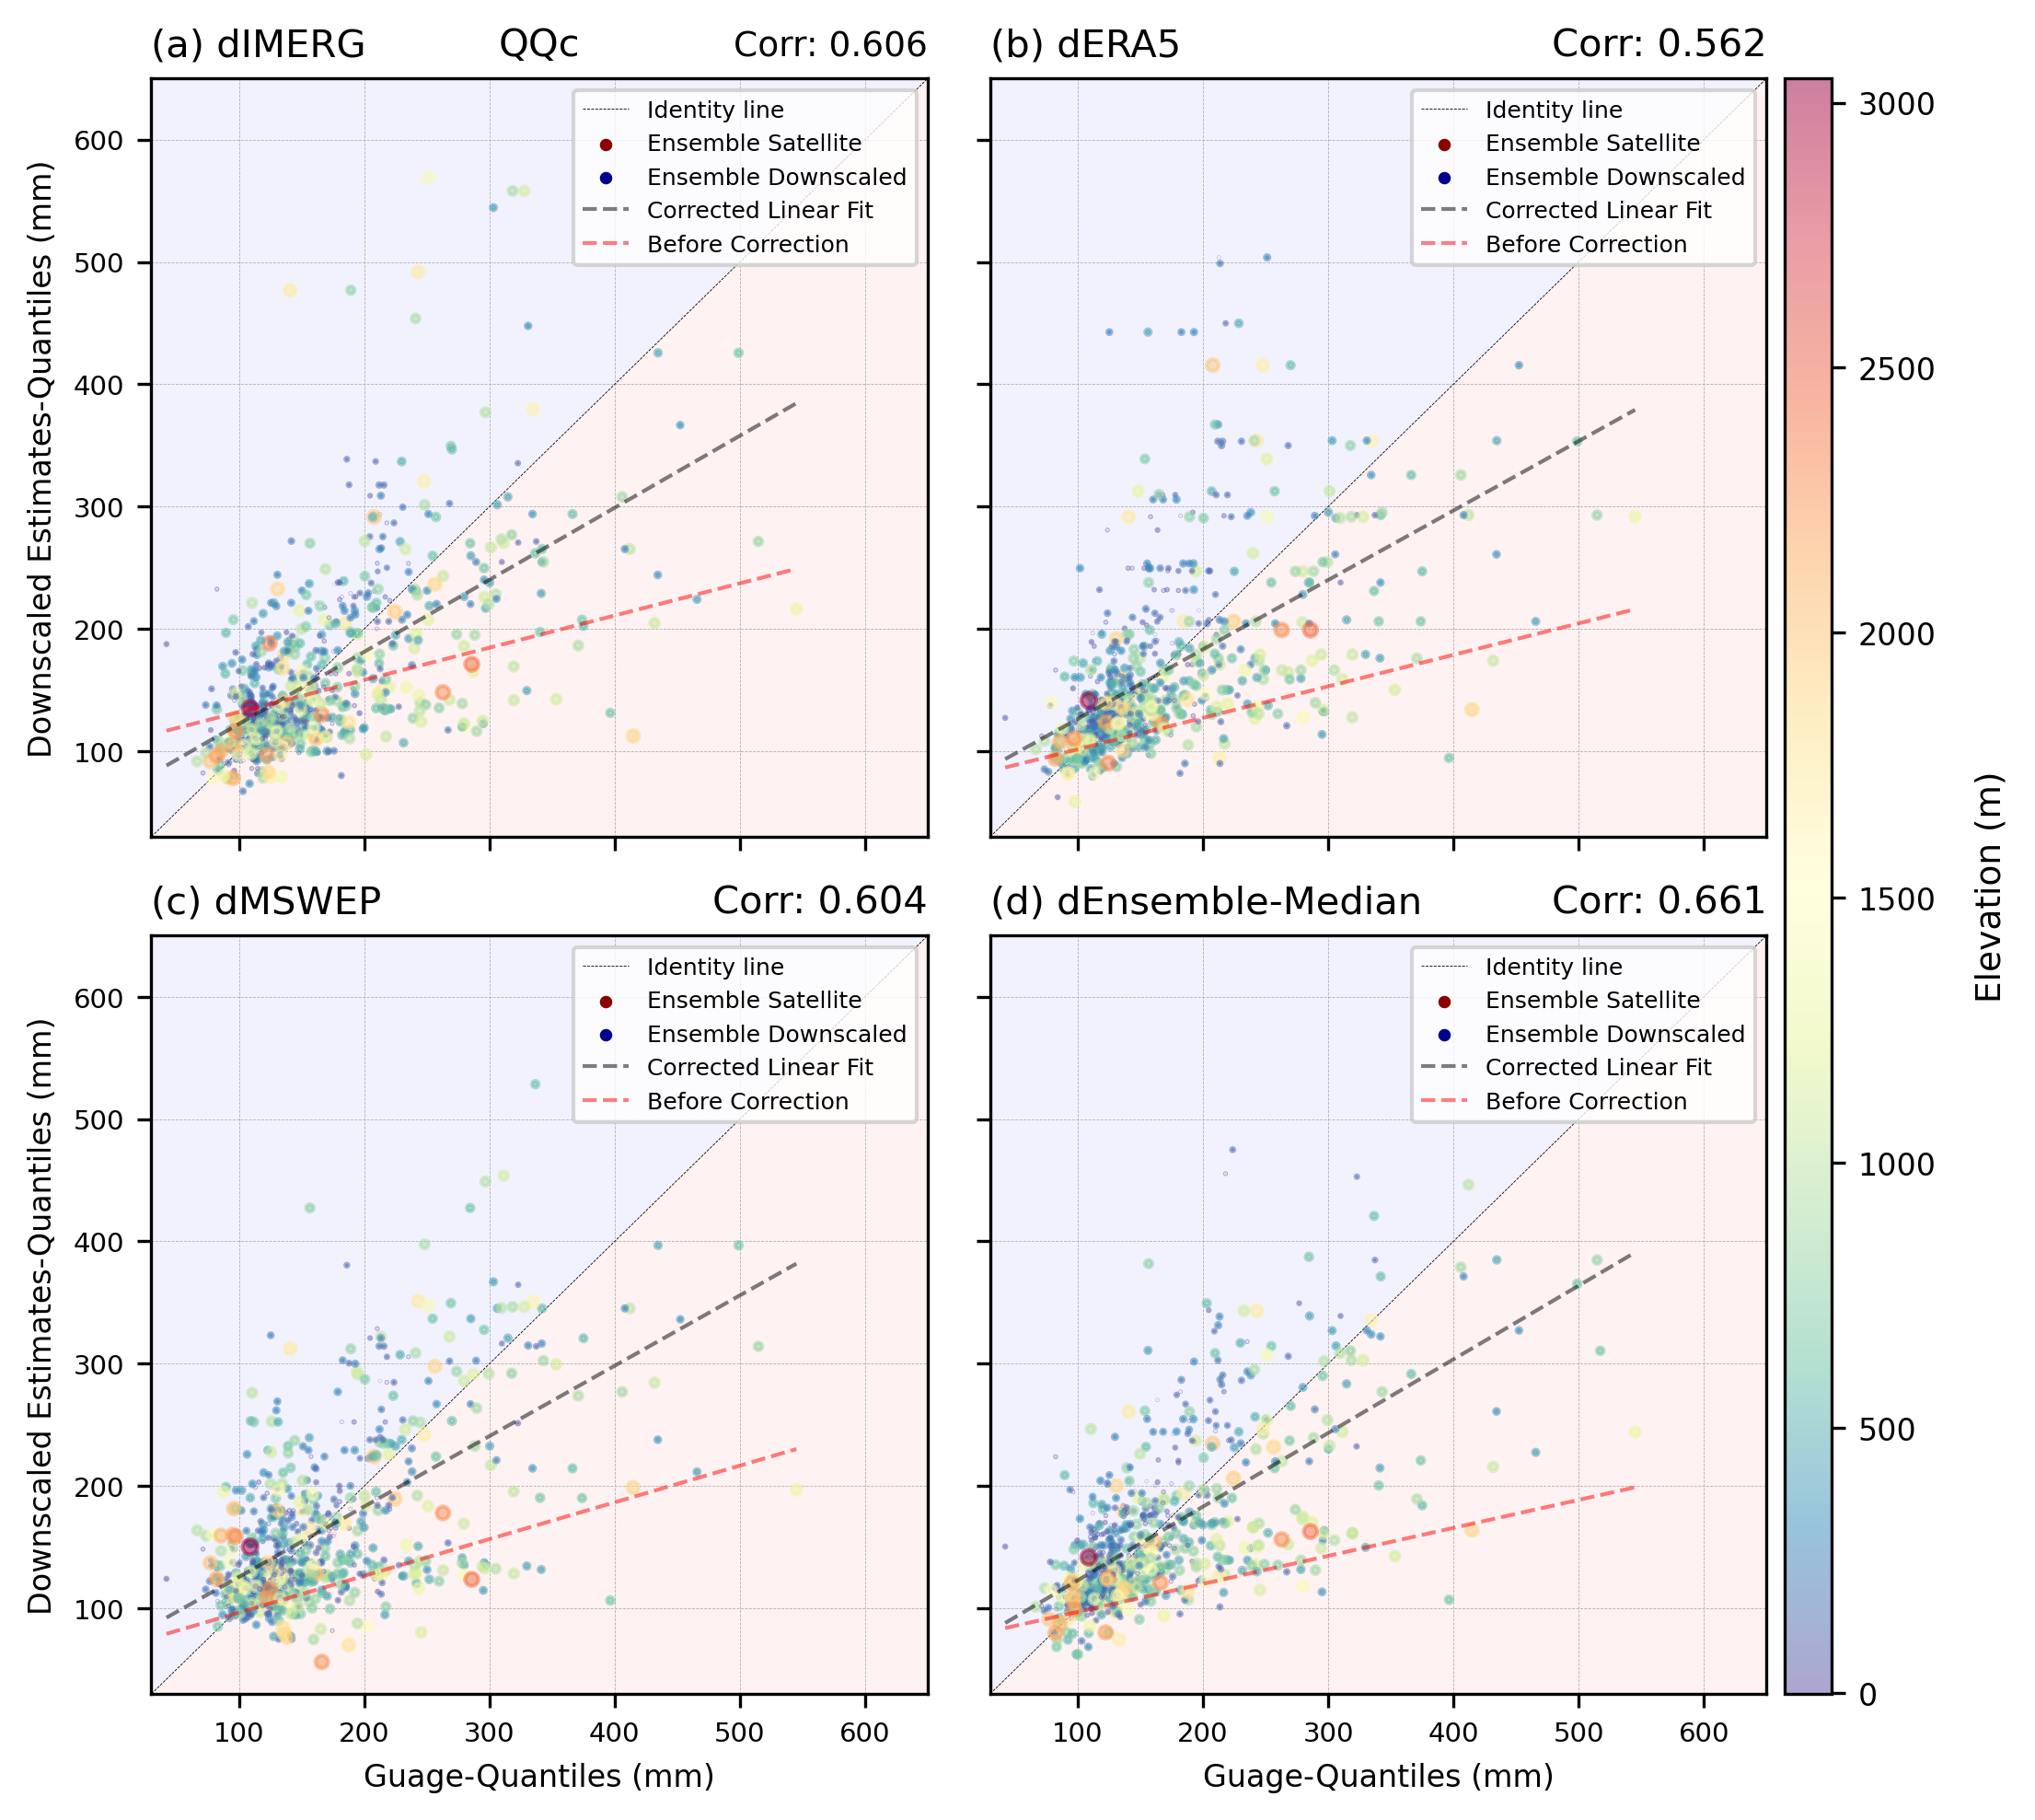

In [66]:
title_fontsize = 10

val_max = 600
vmin = DF_IMERG.ELEV.min()
vmax = DF_IMERG.ELEV.max()

fig = plt.figure(figsize=(6.5,6.5),dpi=300)
gs = gridspec.GridSpec(2, 2)

# ==========================================================================================================
axes = {}
pos = 0
for nrow in range(2):
    for ncol in range(2):
        ax = fig.add_subplot(gs[nrow, ncol])
        ax.grid(linewidth=0.3, linestyle='--')
        ax.set_xlim(30,val_max+50)
        ax.set_ylim(30,val_max+50)
        ax.grid(linestyle='--', linewidth=0.2)
        ax.tick_params(axis='both', which='major', labelsize=7)
        
        ax.plot(np.arange(val_max+50),np.arange(val_max+50),'--k', linewidth=0.2, label='Identity line')
        ax.scatter([],[], s=5, c='darkred', label='Ensemble Satellite')
        ax.scatter([],[], s=5, c='darkblue', label='Ensemble Downscaled')

        if ncol > 0:
            ax.set_yticklabels([])
        if nrow == 0:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel('Guage-Quantiles (mm)',fontsize=8)
        if ncol == 0:
            ax.set_ylabel('Downscaled Estimates-Quantiles (mm)',fontsize=8)

        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        x_vals = np.linspace(min(xlim[0], ylim[0]), max(xlim[1], ylim[1]), 200)
        ax.fill_between(x_vals, ylim[0], x_vals, facecolor="red", alpha=0.05, zorder=0)
        ax.fill_between(x_vals, x_vals, ylim[1], facecolor="blue", alpha=0.05, zorder=0)

        axes[(nrow, ncol)] = ax

# ==========================================================================================================
a1 = axes[(0, 0)].scatter(
    DF_IMERG.OBS, DF_IMERG.QQc,
    alpha=0.5,
    s=DF_IMERG.ELEVn*15,
    c=DF_IMERG.ELEV,
    vmin=vmin, vmax=vmax,
    zorder=10, cmap="Spectral_r")
axes[(0, 0)].plot(IMERG_QQc_x, IMERG_QQc_y, "--k", linewidth=1, label="Corrected Linear Fit", alpha=0.5,zorder=12)
axes[(0, 0)].set_title(f'QQc', loc='center', fontsize=title_fontsize)
axes[(0, 0)].set_title('(a) dIMERG', loc='left', fontsize=10)
axes[(0, 0)].set_title(f'Corr: {corr_IMERG_QQc}', loc='right', fontsize=9)

# ==========================================================================================================
a2 = axes[(0, 1)].scatter(
    DF_ERA5.OBS, DF_ERA5.QQc,
    alpha=0.5,
    s=DF_ERA5.ELEVn*15,
    c=DF_ERA5.ELEV,
    vmin=vmin, vmax=vmax,
    zorder=10, cmap="Spectral_r")
axes[(0, 1)].plot(ERA5_QQc_x, ERA5_QQc_y, "--k", linewidth=1, label="Corrected Linear Fit", alpha=0.5,zorder=12)
axes[(0, 1)].set_title('(b) dERA5', loc='left', fontsize=title_fontsize)
axes[(0, 1)].set_title(f'Corr: {corr_ERA5_QQc}', loc='right', fontsize=title_fontsize)

# ==========================================================================================================
a2 = axes[(1, 0)].scatter(
    DF_MSWEP.OBS, DF_MSWEP.QQc,
    alpha=0.5,
    s=DF_MSWEP.ELEVn*15,
    c=DF_MSWEP.ELEV,
    vmin=vmin, vmax=vmax,
    zorder=10, cmap="Spectral_r")
axes[(1, 0)].plot(MSWEP_QQc_x, MSWEP_QQc_y, "--k", linewidth=1, label="Corrected Linear Fit", alpha=0.5,zorder=12)
axes[(1, 0)].set_title('(c) dMSWEP', loc='left', fontsize=title_fontsize)
axes[(1, 0)].set_title(f'Corr: {corr_MSWEP_QQc}', loc='right', fontsize=title_fontsize)

# ==========================================================================================================
a2 = axes[(1, 1)].scatter(
    DF_ENSEMBLE_MEDIAN.OBS, DF_ENSEMBLE_MEDIAN.QQc,
    alpha=0.5,
    s=DF_ENSEMBLE_MEDIAN.ELEVn*15,
    c=DF_ENSEMBLE_MEDIAN.ELEV,
    vmin=vmin, vmax=vmax,
    zorder=10, cmap="Spectral_r")
axes[(1, 1)].plot(ENSEMBLE_MEDIAN_QQc_x, ENSEMBLE_MEDIAN_QQc_y, "--k", linewidth=1, label="Corrected Linear Fit", alpha=0.5,zorder=12)
axes[(1, 1)].set_title('(d) dEnsemble-Median', loc='left', fontsize=title_fontsize)
axes[(1, 1)].set_title(f'Corr: {corr_ENSEMBLE_MEDIAN_QQc}', loc='right', fontsize=title_fontsize)

# ==========================================================================================================
axes[(0, 0)].plot(IMERG_x, IMERG_y, "--r", linewidth=1, label="Before Correction", alpha=0.5,zorder=12)
axes[(0, 1)].plot(ERA5_x, ERA5_y, "--r", linewidth=1, label="Before Correction", alpha=0.5,zorder=12)
axes[(1, 0)].plot(MSWEP_x, MSWEP_y, "--r", linewidth=1, label="Before Correction", alpha=0.5,zorder=12)
axes[(1, 1)].plot(ENSEMBLE_MEDIAN_x, ENSEMBLE_MEDIAN_y, "--r", linewidth=1, label="Before Correction", alpha=0.5,zorder=12)

axes[(0, 0)].legend(fontsize=6,loc=1)
axes[(0, 1)].legend(fontsize=6,loc=1)
axes[(1, 0)].legend(fontsize=6,loc=1)
axes[(1, 1)].legend(fontsize=6,loc=1)

# ==========================================================================================================
# ==========================================================================================================
cbar_ax = fig.add_axes([0.96, 0.05, 0.026, 0.9]) #0.96
cbar = fig.colorbar(a1, cax=cbar_ax, orientation='vertical')
cbar.ax.tick_params(labelsize=8)
cbar.set_label("Elevation (m)", fontsize=9, labelpad=10) 

# ==========================================================================================================
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.08, hspace=0.13)


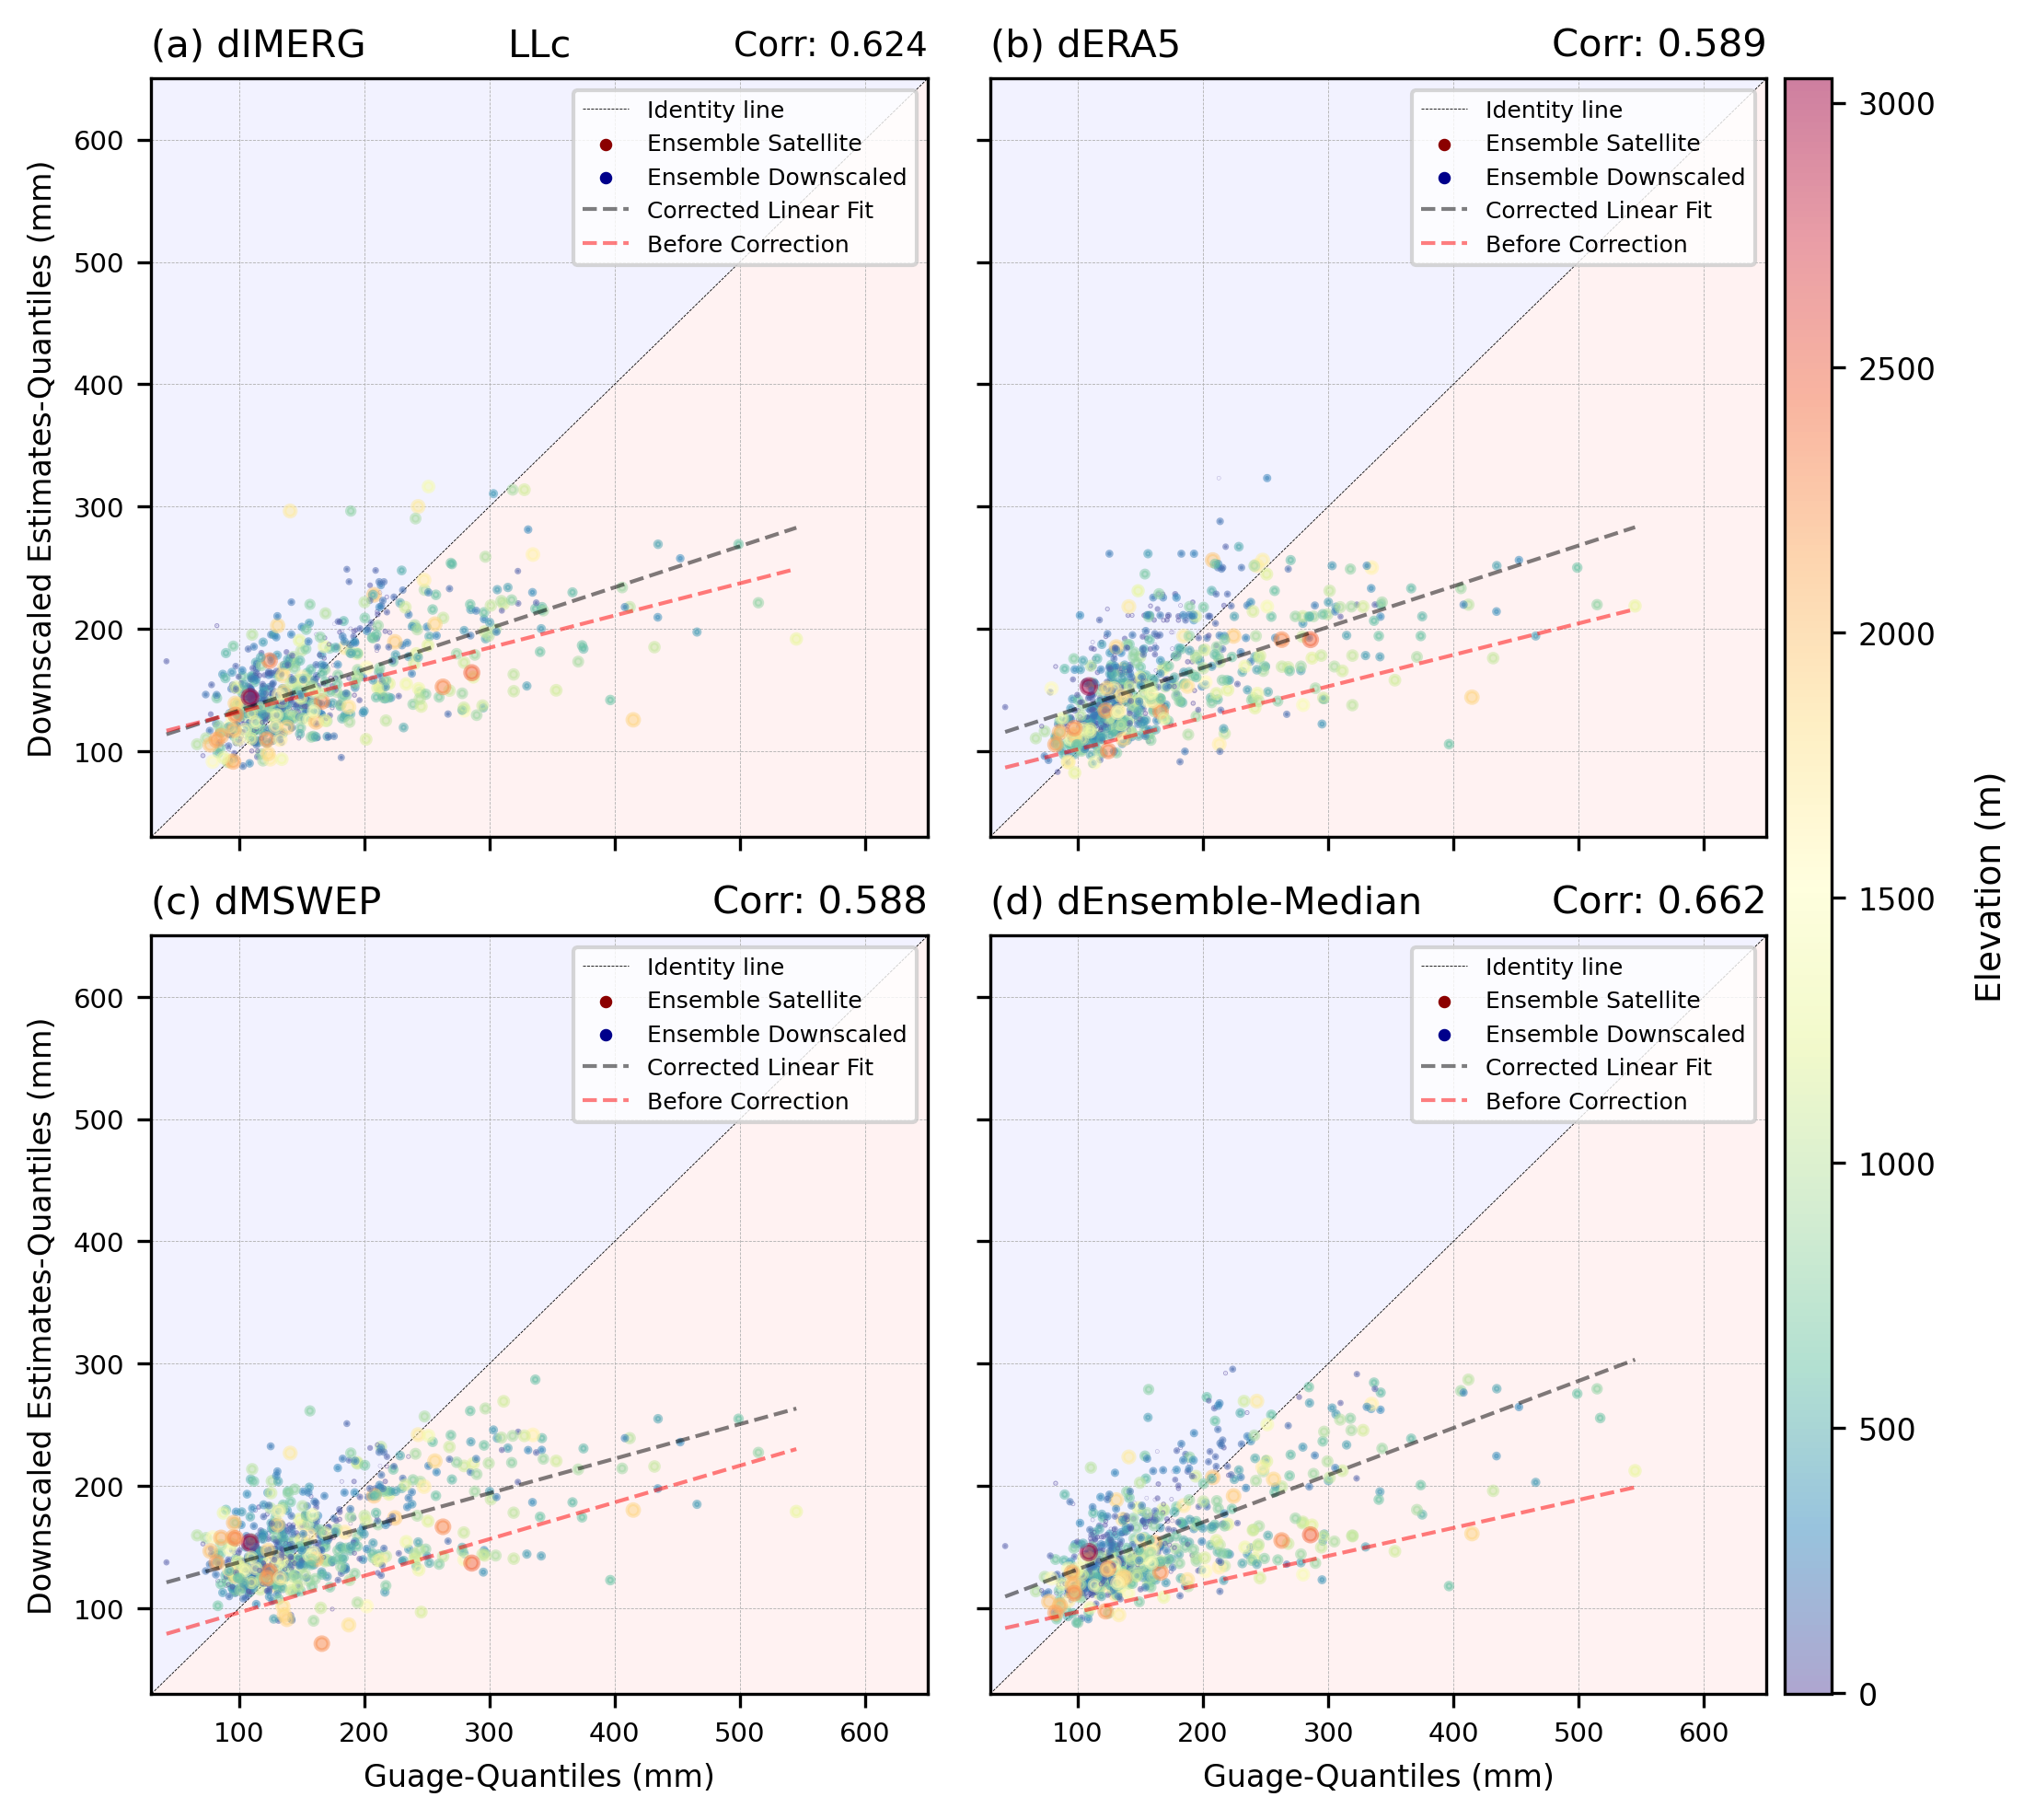

In [67]:
title_fontsize = 10

val_max = 600
vmin = DF_IMERG.ELEV.min()
vmax = DF_IMERG.ELEV.max()

fig = plt.figure(figsize=(6.5,6.5),dpi=300)
gs = gridspec.GridSpec(2, 2)

# ==========================================================================================================
axes = {}
pos = 0
for nrow in range(2):
    for ncol in range(2):
        ax = fig.add_subplot(gs[nrow, ncol])
        ax.grid(linewidth=0.3, linestyle='--')
        ax.set_xlim(30,val_max+50)
        ax.set_ylim(30,val_max+50)
        ax.grid(linestyle='--', linewidth=0.2)
        ax.tick_params(axis='both', which='major', labelsize=7)
        
        ax.plot(np.arange(val_max+50),np.arange(val_max+50),'--k', linewidth=0.2, label='Identity line')
        ax.scatter([],[], s=5, c='darkred', label='Ensemble Satellite')
        ax.scatter([],[], s=5, c='darkblue', label='Ensemble Downscaled')

        if ncol > 0:
            ax.set_yticklabels([])
        if nrow == 0:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel('Guage-Quantiles (mm)',fontsize=8)
        if ncol == 0:
            ax.set_ylabel('Downscaled Estimates-Quantiles (mm)',fontsize=8)

        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        x_vals = np.linspace(min(xlim[0], ylim[0]), max(xlim[1], ylim[1]), 200)
        ax.fill_between(x_vals, ylim[0], x_vals, facecolor="red", alpha=0.05, zorder=0)
        ax.fill_between(x_vals, x_vals, ylim[1], facecolor="blue", alpha=0.05, zorder=0)

        axes[(nrow, ncol)] = ax

# ==========================================================================================================
a1 = axes[(0, 0)].scatter(
    DF_IMERG.OBS, DF_IMERG.LLc,
    alpha=0.5,
    s=DF_IMERG.ELEVn*15,
    c=DF_IMERG.ELEV,
    vmin=vmin, vmax=vmax,
    zorder=10, cmap="Spectral_r")
axes[(0, 0)].plot(IMERG_LLc_x, IMERG_LLc_y, "--k", linewidth=1, label="Corrected Linear Fit", alpha=0.5,zorder=12)
axes[(0, 0)].set_title(f'LLc', loc='center', fontsize=title_fontsize)
axes[(0, 0)].set_title('(a) dIMERG', loc='left', fontsize=10)
axes[(0, 0)].set_title(f'Corr: {corr_IMERG_LLc}', loc='right', fontsize=9)

# ==========================================================================================================
a2 = axes[(0, 1)].scatter(
    DF_ERA5.OBS, DF_ERA5.LLc,
    alpha=0.5,
    s=DF_ERA5.ELEVn*15,
    c=DF_ERA5.ELEV,
    vmin=vmin, vmax=vmax,
    zorder=10, cmap="Spectral_r")
axes[(0, 1)].plot(ERA5_LLc_x, ERA5_LLc_y, "--k", linewidth=1, label="Corrected Linear Fit", alpha=0.5,zorder=12)
axes[(0, 1)].set_title('(b) dERA5', loc='left', fontsize=title_fontsize)
axes[(0, 1)].set_title(f'Corr: {corr_ERA5_LLc}', loc='right', fontsize=title_fontsize)

# ==========================================================================================================
a2 = axes[(1, 0)].scatter(
    DF_MSWEP.OBS, DF_MSWEP.LLc,
    alpha=0.5,
    s=DF_MSWEP.ELEVn*15,
    c=DF_MSWEP.ELEV,
    vmin=vmin, vmax=vmax,
    zorder=10, cmap="Spectral_r")
axes[(1, 0)].plot(MSWEP_LLc_x, MSWEP_LLc_y, "--k", linewidth=1, label="Corrected Linear Fit", alpha=0.5,zorder=12)
axes[(1, 0)].set_title('(c) dMSWEP', loc='left', fontsize=title_fontsize)
axes[(1, 0)].set_title(f'Corr: {corr_MSWEP_LLc}', loc='right', fontsize=title_fontsize)

# ==========================================================================================================
a2 = axes[(1, 1)].scatter(
    DF_ENSEMBLE_MEDIAN.OBS, DF_ENSEMBLE_MEDIAN.LLc,
    alpha=0.5,
    s=DF_ENSEMBLE_MEDIAN.ELEVn*15,
    c=DF_ENSEMBLE_MEDIAN.ELEV,
    vmin=vmin, vmax=vmax,
    zorder=10, cmap="Spectral_r")
axes[(1, 1)].plot(ENSEMBLE_MEDIAN_LLc_x, ENSEMBLE_MEDIAN_LLc_y, "--k", linewidth=1, label="Corrected Linear Fit", alpha=0.5,zorder=12)
axes[(1, 1)].set_title('(d) dEnsemble-Median', loc='left', fontsize=title_fontsize)
axes[(1, 1)].set_title(f'Corr: {corr_ENSEMBLE_MEDIAN_LLc}', loc='right', fontsize=title_fontsize)

# ==========================================================================================================
axes[(0, 0)].plot(IMERG_x, IMERG_y, "--r", linewidth=1, label="Before Correction", alpha=0.5,zorder=12)
axes[(0, 1)].plot(ERA5_x, ERA5_y, "--r", linewidth=1, label="Before Correction", alpha=0.5,zorder=12)
axes[(1, 0)].plot(MSWEP_x, MSWEP_y, "--r", linewidth=1, label="Before Correction", alpha=0.5,zorder=12)
axes[(1, 1)].plot(ENSEMBLE_MEDIAN_x, ENSEMBLE_MEDIAN_y, "--r", linewidth=1, label="Before Correction", alpha=0.5,zorder=12)

axes[(0, 0)].legend(fontsize=6,loc=1)
axes[(0, 1)].legend(fontsize=6,loc=1)
axes[(1, 0)].legend(fontsize=6,loc=1)
axes[(1, 1)].legend(fontsize=6,loc=1)

# ==========================================================================================================
# ==========================================================================================================
cbar_ax = fig.add_axes([0.96, 0.05, 0.026, 0.9]) #0.96
cbar = fig.colorbar(a1, cax=cbar_ax, orientation='vertical')
cbar.ax.tick_params(labelsize=8)
cbar.set_label("Elevation (m)", fontsize=9, labelpad=10) 

# ==========================================================================================================
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.08, hspace=0.13)


In [ ]:
datasets_keep = ['IMERG', 'ERA5', 'MSWEP', 'ENSEMBLE MEDIAN']

RSR_DOWN_compare = (RSR_DOWN[RSR_DOWN['Dataset'].isin(datasets_keep)].reset_index(drop=True))
RSR_DOWN_compare['Dataset'] = RSR_DOWN_compare['Dataset'].replace('IMERG','dIMERG')
RSR_DOWN_compare['Dataset'] = RSR_DOWN_compare['Dataset'].replace('MSWEP','dMSWEP')
RSR_DOWN_compare['Dataset'] = RSR_DOWN_compare['Dataset'].replace('ERA5','dERA5')
RSR_DOWN_compare['Dataset'] = RSR_DOWN_compare['Dataset'].replace('ENSEMBLE MEDIAN','dEnsemble-Median')

RSR_QQc_compare = (RSR_QQc[RSR_QQc['Dataset'].isin(datasets_keep)].reset_index(drop=True))
RSR_QQc_compare['Dataset'] = RSR_QQc_compare['Dataset'].replace('IMERG','dIMERG QQC')
RSR_QQc_compare['Dataset'] = RSR_QQc_compare['Dataset'].replace('MSWEP','dMSWEP QQc')
RSR_QQc_compare['Dataset'] = RSR_QQc_compare['Dataset'].replace('ERA5','dERA5 QQc')
RSR_QQc_compare['Dataset'] = RSR_QQc_compare['Dataset'].replace('ENSEMBLE MEDIAN','dEnsemble-Median QQc')

RSR_LLc_compare = (RSR_LLc[RSR_LLc['Dataset'].isin(datasets_keep)].reset_index(drop=True))
RSR_LLc_compare['Dataset'] = RSR_LLc_compare['Dataset'].replace('IMERG','dIMERG LLc')
RSR_LLc_compare['Dataset'] = RSR_LLc_compare['Dataset'].replace('MSWEP','dMSWEP LLc')
RSR_LLc_compare['Dataset'] = RSR_LLc_compare['Dataset'].replace('ERA5','dERA5 LLc')
RSR_LLc_compare['Dataset'] = RSR_LLc_compare['Dataset'].replace('ENSEMBLE MEDIAN','dEnsemble-Median LLc')

colors = ['royalblue','r', 'g', 'c', 'y', 'purple', 'orange', 'cyan']

RSR_DOWN_QQc = pd.concat(
    [RSR_DOWN_compare, RSR_QQc_compare],
    axis=0,
    ignore_index=True
)

RSR_DOWN_LLc = pd.concat(
    [RSR_DOWN_compare, RSR_LLc_compare],
    axis=0,
    ignore_index=True
)

RSR_QQc_LLc = pd.concat(
    [RSR_QQc_compare, RSR_LLc_compare],
    axis=0,
    ignore_index=True
)

colors_T = [colors[0], colors[2], colors[3], 'k', 
            colors[0], colors[2], colors[3], 'k',]

markers_T = ['o', 'o', 'o', 'o', '^', '^', '^', '^']

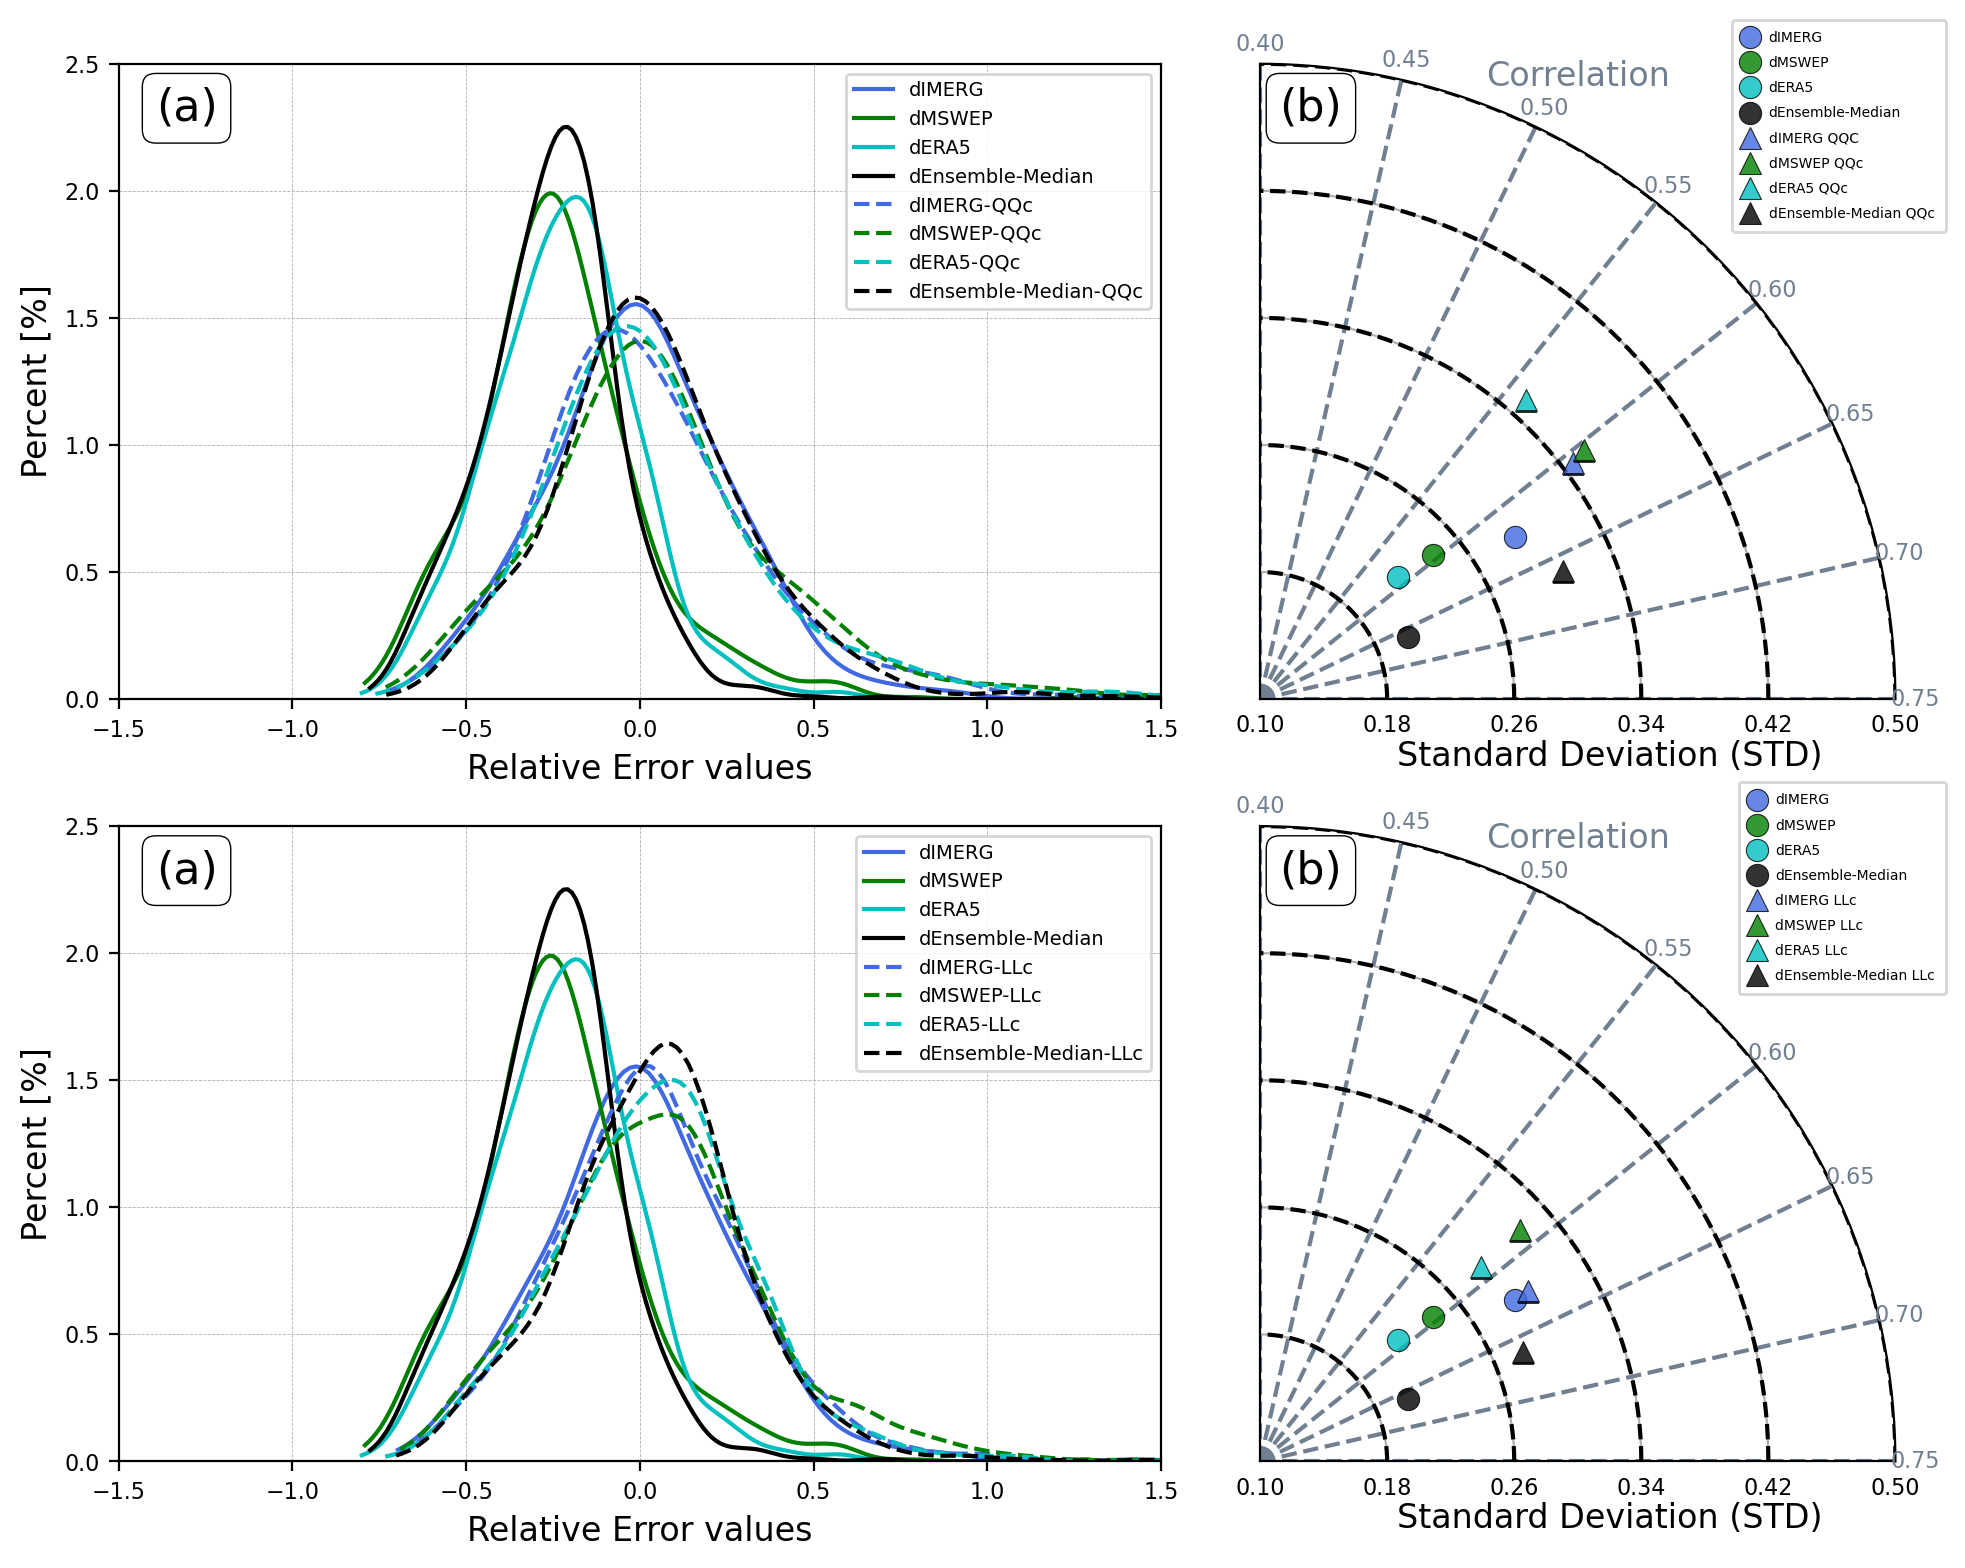

In [71]:
fig = plt.figure(figsize=(11,12),dpi=200)
gs = gridspec.GridSpec(3,2)

# =====================================================================================================================================================
# =====================================================================================================================================================
ax1 = plt.subplot(gs[0, 0])

sns.kdeplot(DF_IMERG.RDown,color=colors[0],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dIMERG',
            clip=(np.nanmin(np.array(DF_IMERG.RDown)), np.nanmax(np.array(DF_IMERG.RDown))))
sns.kdeplot(DF_MSWEP.RDown,color=colors[2],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dMSWEP',
            clip=(np.nanmin(np.array(DF_MSWEP.RDown)), np.nanmax(np.array(DF_MSWEP.RDown))))
sns.kdeplot(DF_ERA5.RDown,color=colors[3],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dERA5',
            clip=(np.nanmin(np.array(DF_ERA5.RDown)), np.nanmax(np.array(DF_ERA5.RDown))))
sns.kdeplot(DF_ENSEMBLE_MEDIAN.RDown,color='k',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dEnsemble-Median',
            clip=(np.nanmin(np.array(DF_ENSEMBLE_MEDIAN.RDown)), np.nanmax(np.array(DF_ENSEMBLE_MEDIAN.RDown))))

sns.kdeplot(DF_IMERG.RQQc,color=colors[0], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dIMERG-QQc',
            clip=(np.nanmin(np.array(DF_IMERG.RQQc)), np.nanmax(np.array(DF_IMERG.RQQc))))
sns.kdeplot(DF_MSWEP.RQQc,color=colors[2], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dMSWEP-QQc',
            clip=(np.nanmin(np.array(DF_MSWEP.RQQc)), np.nanmax(np.array(DF_MSWEP.RQQc))))
sns.kdeplot(DF_ERA5.RQQc,color=colors[3], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dERA5-QQc',
            clip=(np.nanmin(np.array(DF_ERA5.RQQc)), np.nanmax(np.array(DF_ERA5.RQQc))))
sns.kdeplot(DF_ENSEMBLE_MEDIAN.RQQc,color='k', linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dEnsemble-Median-QQc',
            clip=(np.nanmin(np.array(DF_ENSEMBLE_MEDIAN.RQQc)), np.nanmax(np.array(DF_ENSEMBLE_MEDIAN.RQQc))))

ax1.set_ylabel('Percent [%]',fontsize=12)
ax1.set_xlabel('Relative Error values',fontsize=12)
ax1.legend(fontsize=7, loc=0, ncol=1)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_xlim(-1.5,1.5)
ax1.set_ylim(0,2.5)
ax1.tick_params(axis='both', which='major', labelsize=8)

ax1.text(0.065, 0.93, '(a)', 
            fontsize=16, ha='center', va='center',
            transform=ax1.transAxes, zorder=20,
            bbox=dict(boxstyle="round,pad=0.3", 
                facecolor="white", 
                alpha=1,
                edgecolor="black",
                linewidth=0.5))

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 1], polar=True)

rmin = 0.1
rmax = 0.5

c_min = 0.4
c_max = 0.75
correlations = np.arange(c_min, c_max + 0.05, 0.05)

for c in correlations:
    theta = (c_max - c) / (c_max - c_min) * (np.pi/2)
    ax1.plot([theta, theta], [rmin, rmax], color="slategrey", linestyle="--")
    ax1.text(theta, rmax * 1.025, f"{c:.2f}", ha="center", va="center",
            fontsize=8, color="slategrey")

# --- NUEVOS CÍRCULOS RADIALES DE MARE ---
radial_ticks = np.linspace(rmin, rmax, 6)
for r in radial_ticks:
    ax1.plot(np.linspace(0, np.pi/2, 200), np.ones(200)*r, color="k", linestyle="--")

# --- LIMPIEZA DE EJE ANGULAR ---
ax1.xaxis.set_visible(False)

# --- PUNTOS DE MODELOS ---
for rmse_val, corr_val, lab, co, ma in zip(RSR_DOWN_QQc.STD.values, RSR_DOWN_QQc.CORR.values, RSR_DOWN_QQc.Dataset.values, colors_T, markers_T):
    theta = (c_max - corr_val) / (c_max - c_min) * (np.pi/2)
    ax1.plot(theta, rmse_val, ma, markersize=8, 
            markeredgecolor='black',
            markeredgewidth=0.4,
            alpha=0.8, label=f'{lab}', color=co)

# --- LÍMITES Y DIRECCIÓN ---
ax1.set_thetamin(0)
ax1.set_thetamax(90)
ax1.set_theta_zero_location("E")
ax1.set_theta_direction(1)
ax1.set_rmin(rmin)
ax1.set_rmax(rmax)

# --- RADIAL TICKS ---
ax1.set_yticks(radial_ticks)
ax1.tick_params(axis='both', which='major', labelsize=8, pad=2)
ax1.grid(True)

# plt.legend(fontsize=5, ncol=1, loc='upper right', bbox_to_anchor=(1.09, 1.08))
plt.legend(fontsize=5, 
            ncol=1, 
            loc='upper right', 
            bbox_to_anchor=(1.09, 1.08),
            handlelength=1.0,      # Longitud de la línea del símbolo
            handletextpad=0.8,     # Espacio entre símbolo y texto
            borderpad=0.8,         # Padding interno
            labelspacing=0.8)      # Espacio entre etiquetas

# --- LABELS ---
# ax1.text(0.55, -0.09, "Mean Absolute Relative Error (MARE)", transform=ax1.transAxes,ha="center", va="center", fontsize=12)
ax1.text(0.55, -0.09, "Standard Deviation (STD)", transform=ax1.transAxes,ha="center", va="center", fontsize=12)

ax1.text(0.5, 0.98, "Correlation", transform=ax1.transAxes,
        ha="center", va="center", rotation=0, fontsize=12, color='slategrey')

ax1.text(0.08, 0.93, '(b)', 
            fontsize=16, ha='center', va='center',
            transform=ax1.transAxes, zorder=20,
            bbox=dict(boxstyle="round,pad=0.3", 
                facecolor="white", 
                alpha=1,
                edgecolor="black",
                linewidth=0.5))

# =====================================================================================================================================================
# =====================================================================================================================================================
ax1 = plt.subplot(gs[1, 0])

sns.kdeplot(DF_IMERG.RDown,color=colors[0],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dIMERG',
            clip=(np.nanmin(np.array(DF_IMERG.RDown)), np.nanmax(np.array(DF_IMERG.RDown))))
sns.kdeplot(DF_MSWEP.RDown,color=colors[2],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dMSWEP',
            clip=(np.nanmin(np.array(DF_MSWEP.RDown)), np.nanmax(np.array(DF_MSWEP.RDown))))
sns.kdeplot(DF_ERA5.RDown,color=colors[3],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dERA5',
            clip=(np.nanmin(np.array(DF_ERA5.RDown)), np.nanmax(np.array(DF_ERA5.RDown))))
sns.kdeplot(DF_ENSEMBLE_MEDIAN.RDown,color='k',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dEnsemble-Median',
            clip=(np.nanmin(np.array(DF_ENSEMBLE_MEDIAN.RDown)), np.nanmax(np.array(DF_ENSEMBLE_MEDIAN.RDown))))

sns.kdeplot(DF_IMERG.RLLc,color=colors[0], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dIMERG-LLc',
            clip=(np.nanmin(np.array(DF_IMERG.RLLc)), np.nanmax(np.array(DF_IMERG.RLLc))))
sns.kdeplot(DF_MSWEP.RLLc,color=colors[2], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dMSWEP-LLc',
            clip=(np.nanmin(np.array(DF_MSWEP.RLLc)), np.nanmax(np.array(DF_MSWEP.RLLc))))
sns.kdeplot(DF_ERA5.RLLc,color=colors[3], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dERA5-LLc',
            clip=(np.nanmin(np.array(DF_ERA5.RLLc)), np.nanmax(np.array(DF_ERA5.RLLc))))
sns.kdeplot(DF_ENSEMBLE_MEDIAN.RLLc,color='k', linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dEnsemble-Median-LLc',
            clip=(np.nanmin(np.array(DF_ENSEMBLE_MEDIAN.RLLc)), np.nanmax(np.array(DF_ENSEMBLE_MEDIAN.RLLc))))

ax1.set_ylabel('Percent [%]',fontsize=12)
ax1.set_xlabel('Relative Error values',fontsize=12)
ax1.legend(fontsize=7, loc=0, ncol=1)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_xlim(-1.5,1.5)
ax1.set_ylim(0,2.5)
ax1.tick_params(axis='both', which='major', labelsize=8)

ax1.text(0.065, 0.93, '(a)', 
            fontsize=16, ha='center', va='center',
            transform=ax1.transAxes, zorder=20,
            bbox=dict(boxstyle="round,pad=0.3", 
                facecolor="white", 
                alpha=1,
                edgecolor="black",
                linewidth=0.5))

# =========================================================================================================================
ax1 = plt.subplot(gs[1, 1], polar=True)

rmin = 0.1
rmax = 0.5

c_min = 0.4
c_max = 0.75
correlations = np.arange(c_min, c_max + 0.05, 0.05)

for c in correlations:
    theta = (c_max - c) / (c_max - c_min) * (np.pi/2)
    ax1.plot([theta, theta], [rmin, rmax], color="slategrey", linestyle="--")
    ax1.text(theta, rmax * 1.025, f"{c:.2f}", ha="center", va="center",
            fontsize=8, color="slategrey")

# --- NUEVOS CÍRCULOS RADIALES DE MARE ---
radial_ticks = np.linspace(rmin, rmax, 6)
for r in radial_ticks:
    ax1.plot(np.linspace(0, np.pi/2, 200), np.ones(200)*r, color="k", linestyle="--")

# --- LIMPIEZA DE EJE ANGULAR ---
ax1.xaxis.set_visible(False)

# --- PUNTOS DE MODELOS ---
for rmse_val, corr_val, lab, co, ma in zip(RSR_DOWN_LLc.STD.values, RSR_DOWN_LLc.CORR.values, RSR_DOWN_LLc.Dataset.values, colors_T, markers_T):
    theta = (c_max - corr_val) / (c_max - c_min) * (np.pi/2)
    ax1.plot(theta, rmse_val, ma, markersize=8, 
            markeredgecolor='black',
            markeredgewidth=0.4,
            alpha=0.8, label=f'{lab}', color=co)

# --- LÍMITES Y DIRECCIÓN ---
ax1.set_thetamin(0)
ax1.set_thetamax(90)
ax1.set_theta_zero_location("E")
ax1.set_theta_direction(1)
ax1.set_rmin(rmin)
ax1.set_rmax(rmax)

# --- RADIAL TICKS ---
ax1.set_yticks(radial_ticks)
ax1.tick_params(axis='both', which='major', labelsize=8, pad=2)
ax1.grid(True)

# plt.legend(fontsize=5, ncol=1, loc='upper right', bbox_to_anchor=(1.09, 1.08))
plt.legend(fontsize=5, 
            ncol=1, 
            loc='upper right', 
            bbox_to_anchor=(1.09, 1.08),
            handlelength=1.0,      # Longitud de la línea del símbolo
            handletextpad=0.8,     # Espacio entre símbolo y texto
            borderpad=0.8,         # Padding interno
            labelspacing=0.8)      # Espacio entre etiquetas

# --- LABELS ---
# ax1.text(0.55, -0.09, "Mean Absolute Relative Error (MARE)", transform=ax1.transAxes,ha="center", va="center", fontsize=12)
ax1.text(0.55, -0.09, "Standard Deviation (STD)", transform=ax1.transAxes,ha="center", va="center", fontsize=12)

ax1.text(0.5, 0.98, "Correlation", transform=ax1.transAxes,
        ha="center", va="center", rotation=0, fontsize=12, color='slategrey')

ax1.text(0.08, 0.93, '(b)', 
            fontsize=16, ha='center', va='center',
            transform=ax1.transAxes, zorder=20,
            bbox=dict(boxstyle="round,pad=0.3", 
                facecolor="white", 
                alpha=1,
                edgecolor="black",
                linewidth=0.5))

# ============================================================================================================================
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=-0.1, hspace=0.2)

# salida = '../figures/Article_down/Scatter_FOCUS_RE_corected.png'
# print(salida)
# plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor=None)

In [72]:
lon_min, lon_max, lat_min, lat_max, area, toll = 6.5, 19, 36.5, 48, 'ITALY', 0.002

Tr = [5,  10,  20,  50, 100, 200]
Fi = 1 - 1/np.array(Tr)

veneto_dir = os.path.join('/','media','arturo','T9','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    REGIONS = gpd.read_file(os.path.join(veneto_dir,'Italy_regions.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

obs_base = os.path.join('/','media','arturo','T9','Data','Italy','Rain_Gauges_QC')
bias_base = os.path.join('/','media','arturo','T9','Data','Italy','Satellite','6_DOWN_BCorrected','TEST')

METADATA = pd.read_csv(os.path.join(obs_base, 'data', 'METADATA', 'METADATA_FTS_QCv4_Case1_wAIRHO_v3_1dy.csv'))
METADATA["Lat"] = np.round(METADATA["Lat"], 6)
METADATA["Lon"] = np.round(METADATA["Lon"], 6)

In [73]:
ISO_names = np.unique(METADATA.ISO.values)

lats, lons = [], []
QUANTILE = []

for rr in range(len(ISO_names)):
    region_ISO = ISO_names[rr]

    INFO_dict = {}
    WEIBULL_dict = {}
    QUANTILES_dict = {}

    # print(f'{rr+1}: {region_ISO}')

    METADATA_clear = METADATA[METADATA['ISO']==region_ISO].reset_index(inplace=False)

    for nn in range(len(METADATA_clear)):#len(METADATA_clear)
        filename = f'{METADATA_clear['File'].values[nn]}'
        lat_obs = METADATA_clear['Lat'][nn]
        lon_obs = METADATA_clear['Lon'][nn]
        elev_obs = METADATA_clear['DEM_Elevation'][nn]

        OBS_pd = pd.read_csv(os.path.join(obs_base, 'Weibull', '1dy', region_ISO, filename))
        OBS_pd = OBS_pd[(OBS_pd['Year']>=2002)&(OBS_pd['Year']<=2023)].reset_index(drop=True)
        
        if len(OBS_pd) == 0:
            continue

        else:
            OBS_N = OBS_pd['N'].values
            OBS_C = OBS_pd['C'].values
            OBS_W = OBS_pd['W'].values
            OBS_Y = OBS_pd['Year'].values

            mask = ~np.isnan(OBS_N)

            OBS_N = OBS_N[mask]
            OBS_C = OBS_C[mask]
            OBS_W = OBS_W[mask]
            OBS_Y = OBS_Y[mask]

            if len(OBS_Y) >= 8: # greather than 8 years

                x0 = np.nanmean(OBS_C)
                OBS_Q, flag = DOWN_raw.mev_quant_update(Fi, x0, OBS_N, OBS_C, OBS_W, thresh=1)
                OBS_Q2 = np.where(flag, OBS_Q, np.nan)

                lats.append(lat_obs)
                lons.append(lon_obs)
                QUANTILE.append(OBS_Q2[3])

Quantile_pd = pd.DataFrame({'lat':lats,'lon':lons,'Quantile':QUANTILE})
Quantile_clear = Quantile_pd[Quantile_pd['Quantile']<500]
Q_norm = (Quantile_clear['lat'].values - np.nanmin(Quantile_clear['lat'].values))/(np.nanmax(Quantile_clear['lat'].values)-np.nanmin(Quantile_clear['lat'].values)) *2

In [74]:
Mev_levels = np.arange(60, 390, 10)
Mev_cmap = plt.cm.Spectral_r
norm = BoundaryNorm(Mev_levels, ncolors=Mev_cmap.N, clip=True)

In [ ]:
veneto_dir = os.path.join('/','media','arturo','T9','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    REGIONS = gpd.read_file(os.path.join(veneto_dir,'Italy_regions.geojson'))
    ITALY = gpd.read_file(os.path.join(veneto_dir,'Italy_clear.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

italy_geom = ITALY.union_all()

In [77]:
ENS_base = os.path.join('/','media','arturo','T9','Data','Italy','Satellite','5_ENSEMBLE')

dir_in = os.path.join(ENS_base,f'ITALY_ENSEMBLE_ALL_1dy_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson_median.nc')
DATA = xr.open_dataset(dir_in)
lon2d, lat2d, = np.meshgrid(DATA.lon, DATA.lat)
mask_italy = sv.contains(italy_geom, lon2d, lat2d)

MEVd_Median = DATA.Mev_d.where(mask_italy)

In [78]:
ENS_base = os.path.join('/','media','arturo','T9','Data','Italy','Satellite','6_DOWN_BCorrected','QUANTILE')

dir_in = os.path.join(ENS_base,f'ITALY_DOWN_ENSEMBLE_median_1dy_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson_QQc_LLc_{str(seed).zfill(4)}.nc')
DATA = xr.open_dataset(dir_in)
mask_italy = sv.contains(italy_geom, lon2d, lat2d)

MEVd_Median_QQc = DATA.MEVd_QQc.where(mask_italy)
MEVd_Median_LLc = DATA.MEVd_LLc.where(mask_italy)

../figures/Article_down/Bias_correction_QUANTILES.png


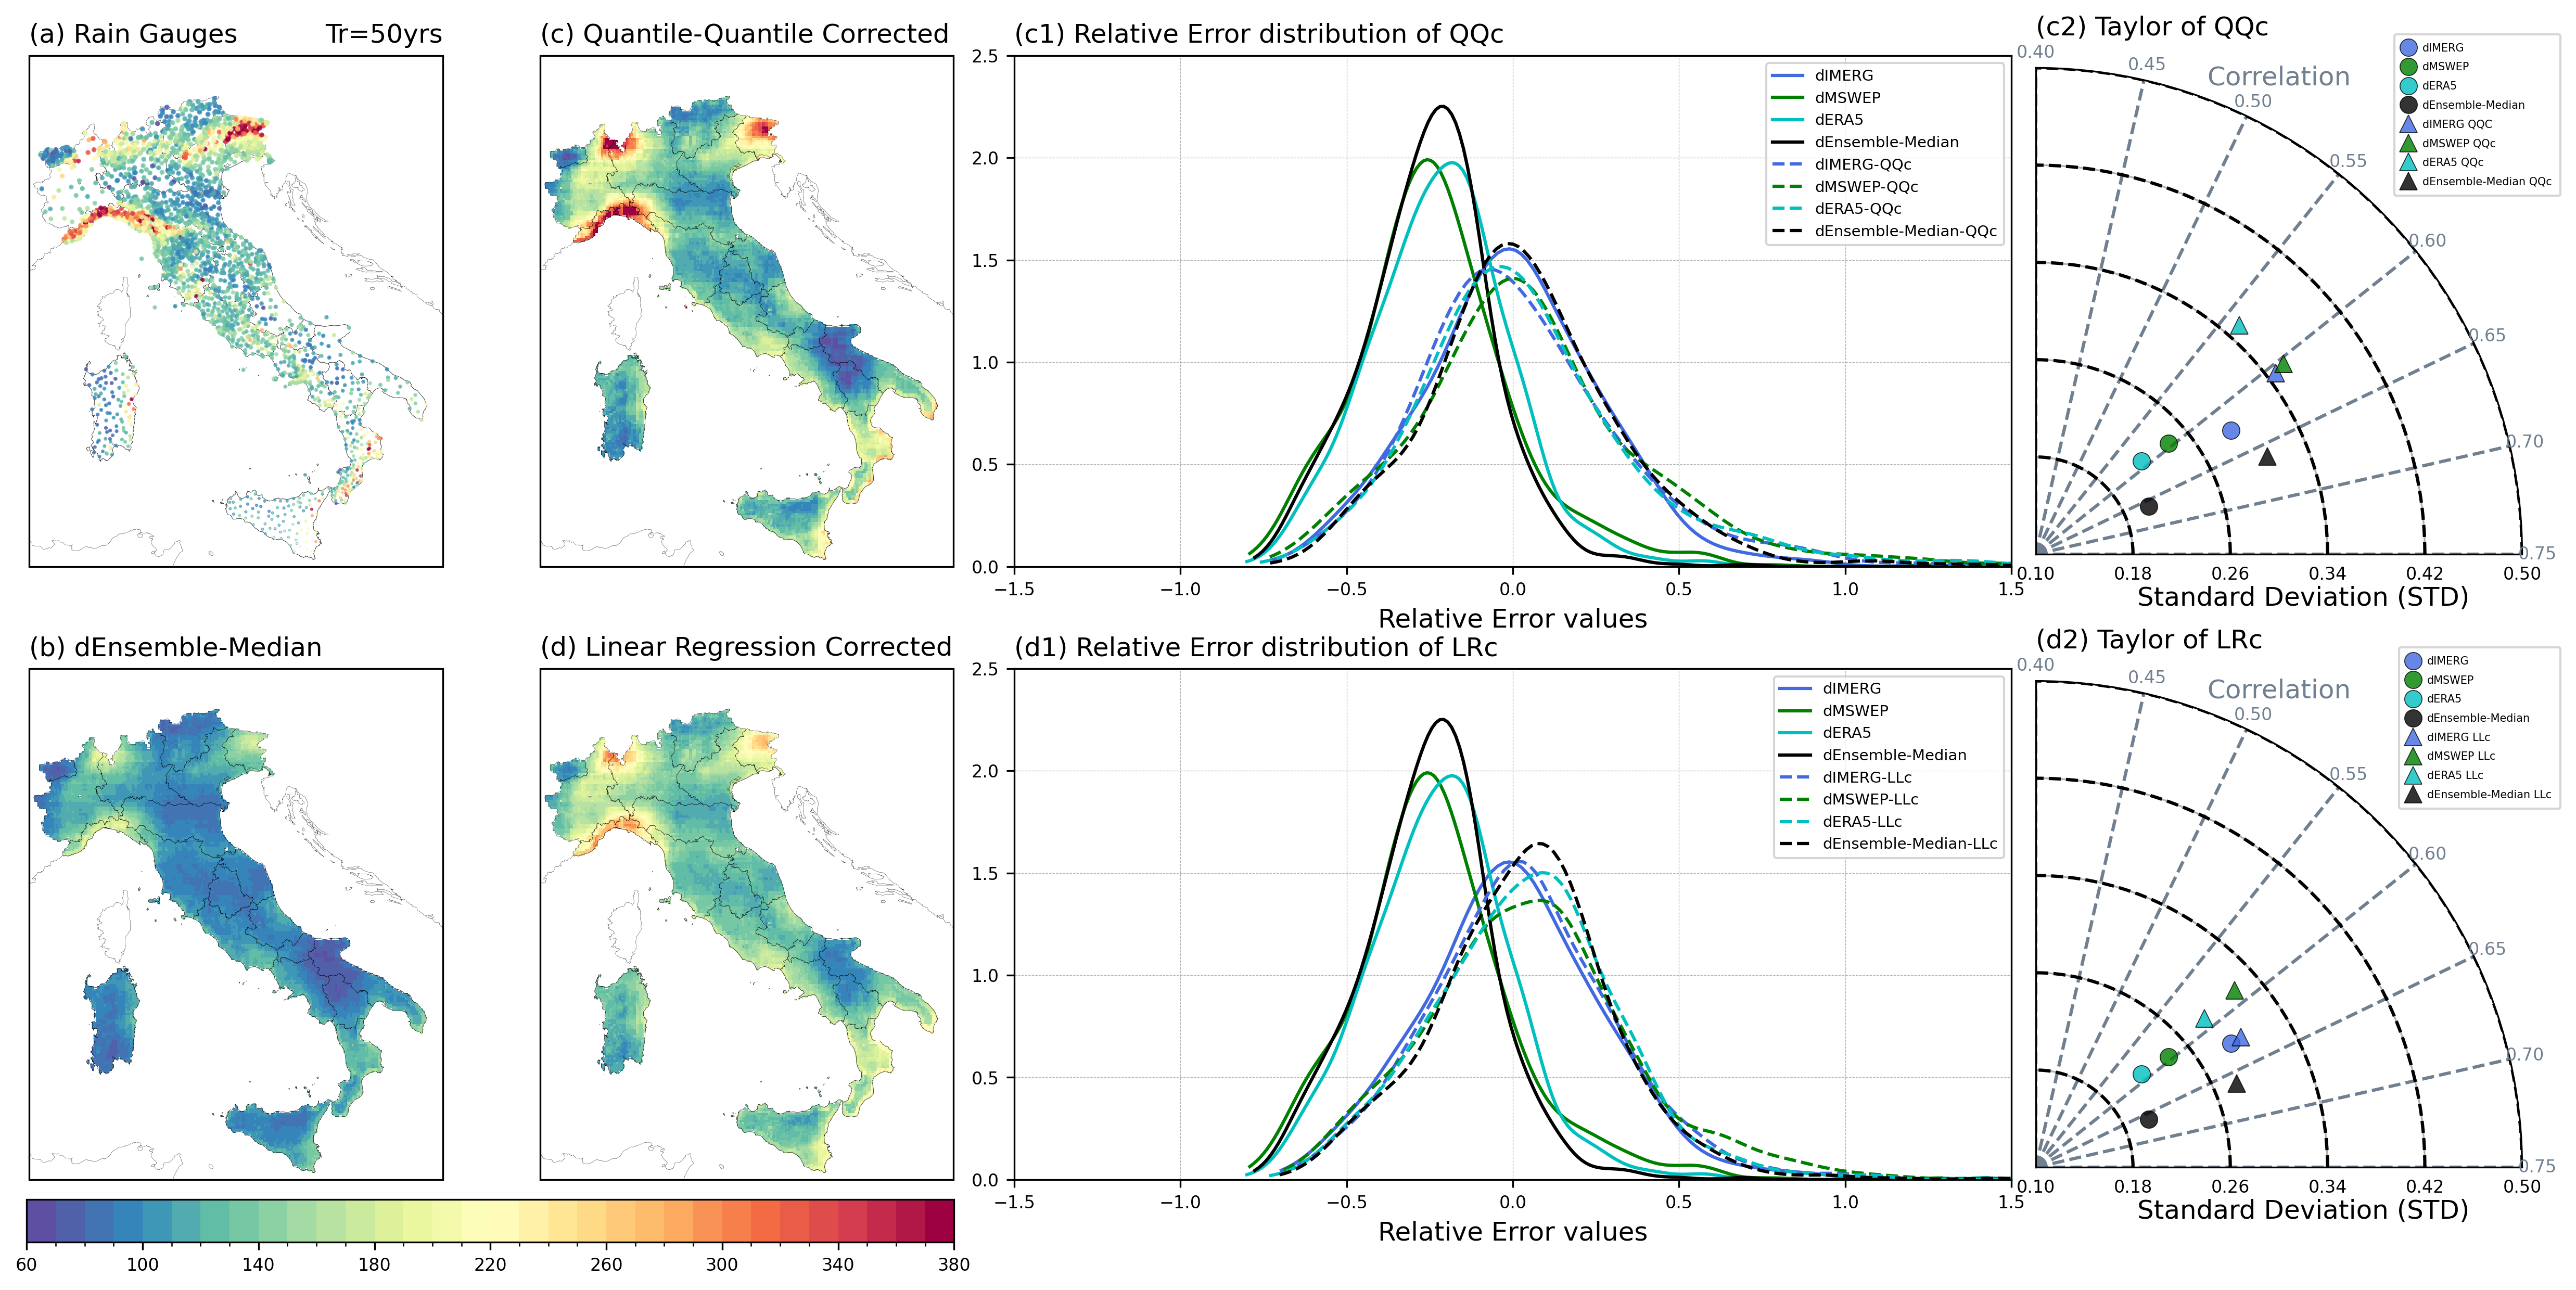

In [79]:
pos = 3

proj = ccrs.PlateCarree()

Mev_cmap = plt.cm.Spectral_r
diff_map = plt.cm.coolwarm_r
norm = mcolors.BoundaryNorm(boundaries=Mev_levels, ncolors=Mev_cmap.N)
# norm_diff = mcolors.BoundaryNorm(boundaries=Diff_levels, ncolors=diff_map.N)

fig = plt.figure(figsize=(18,8),dpi=300)
gs = gridspec.GridSpec(2,5)

# ===========================================================================================================================================================================
# ===========================================================================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.1,edgecolor='k')
# ax1.add_feature(cfeature.BORDERS,linewidth=0.2,edgecolor='black',zorder=4)
im = REGIONS.plot(legend=False, facecolor="none", edgecolor='black', linewidth=0.1, ax=ax1, zorder=10)
a1 = ax1.scatter(Quantile_clear['lon'].values, Quantile_clear['lat'].values, c=Quantile_clear['Quantile'].values, s=Q_norm, alpha=0.8,cmap=Mev_cmap,norm=norm, zorder=10)

ax1.set_title('(a) Rain Gauges', loc='left', fontsize=12)
ax1.set_title('Tr=50yrs', loc='right', fontsize=12)

# ===========================================================================================================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.1,edgecolor='k')
# ax1.add_feature(cfeature.BORDERS,linewidth=0.2,edgecolor='black',zorder=4)
im = REGIONS.plot(legend=False, facecolor="none", edgecolor='black', linewidth=0.1, ax=ax1, zorder=10)
# DEM.plot(facecolor='None', edgecolor='k', ax=ax1, linewidth=0.1, zorder=21, alpha=0.3)
a1 = ax1.pcolormesh(lon2d, lat2d, MEVd_Median_QQc, cmap=Mev_cmap, norm=norm)

# cbar = plt.colorbar(a1, ax=ax1, fraction=0.056, pad=0.04, orientation='horizontal')
# cbar.ax.tick_params(labelsize=6) 

ax1.set_title('(c) Quantile-Quantile Corrected', loc='left', fontsize=12)

# ===========================================================================================================================================================================
ax1 = plt.subplot(gs[0, 2:4])
ax1.set_aspect('auto')
sns.kdeplot(DF_IMERG.RDown,color=colors[0],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dIMERG',
            clip=(np.nanmin(np.array(DF_IMERG.RDown)), np.nanmax(np.array(DF_IMERG.RDown))))
sns.kdeplot(DF_MSWEP.RDown,color=colors[2],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dMSWEP',
            clip=(np.nanmin(np.array(DF_MSWEP.RDown)), np.nanmax(np.array(DF_MSWEP.RDown))))
sns.kdeplot(DF_ERA5.RDown,color=colors[3],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dERA5',
            clip=(np.nanmin(np.array(DF_ERA5.RDown)), np.nanmax(np.array(DF_ERA5.RDown))))
sns.kdeplot(DF_ENSEMBLE_MEDIAN.RDown,color='k',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dEnsemble-Median',
            clip=(np.nanmin(np.array(DF_ENSEMBLE_MEDIAN.RDown)), np.nanmax(np.array(DF_ENSEMBLE_MEDIAN.RDown))))

sns.kdeplot(DF_IMERG.RQQc,color=colors[0], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dIMERG-QQc',
            clip=(np.nanmin(np.array(DF_IMERG.RQQc)), np.nanmax(np.array(DF_IMERG.RQQc))))
sns.kdeplot(DF_MSWEP.RQQc,color=colors[2], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dMSWEP-QQc',
            clip=(np.nanmin(np.array(DF_MSWEP.RQQc)), np.nanmax(np.array(DF_MSWEP.RQQc))))
sns.kdeplot(DF_ERA5.RQQc,color=colors[3], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dERA5-QQc',
            clip=(np.nanmin(np.array(DF_ERA5.RQQc)), np.nanmax(np.array(DF_ERA5.RQQc))))
sns.kdeplot(DF_ENSEMBLE_MEDIAN.RQQc,color='k', linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dEnsemble-Median-QQc',
            clip=(np.nanmin(np.array(DF_ENSEMBLE_MEDIAN.RQQc)), np.nanmax(np.array(DF_ENSEMBLE_MEDIAN.RQQc))))

ax1.set_ylabel('',fontsize=12)
ax1.set_xlabel('Relative Error values',fontsize=12)
ax1.legend(fontsize=7, loc=0, ncol=1)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_xlim(-1.5,1.5)
ax1.set_ylim(0,2.5)
ax1.tick_params(axis='both', which='major', labelsize=8)

ax1.set_title('(c1) Relative Error distribution of QQc', loc='left', fontsize=12)

# ===========================================================================================================================================================================
ax1 = plt.subplot(gs[0, 4], polar=True)

rmin = 0.1
rmax = 0.5

c_min = 0.4
c_max = 0.75
correlations = np.arange(c_min, c_max + 0.05, 0.05)

for c in correlations:
    theta = (c_max - c) / (c_max - c_min) * (np.pi/2)
    ax1.plot([theta, theta], [rmin, rmax], color="slategrey", linestyle="--")
    ax1.text(theta, rmax * 1.025, f"{c:.2f}", ha="center", va="center",
            fontsize=8, color="slategrey")

# --- NUEVOS CÍRCULOS RADIALES DE MARE ---
radial_ticks = np.linspace(rmin, rmax, 6)
for r in radial_ticks:
    ax1.plot(np.linspace(0, np.pi/2, 200), np.ones(200)*r, color="k", linestyle="--")

# --- LIMPIEZA DE EJE ANGULAR ---
ax1.xaxis.set_visible(False)

# --- PUNTOS DE MODELOS ---
for rmse_val, corr_val, lab, co, ma in zip(RSR_DOWN_QQc.STD.values, RSR_DOWN_QQc.CORR.values, RSR_DOWN_QQc.Dataset.values, colors_T, markers_T):
    theta = (c_max - corr_val) / (c_max - c_min) * (np.pi/2)
    ax1.plot(theta, rmse_val, ma, markersize=8, 
            markeredgecolor='black',
            markeredgewidth=0.4,
            alpha=0.8, label=f'{lab}', color=co)

# --- LÍMITES Y DIRECCIÓN ---
ax1.set_thetamin(0)
ax1.set_thetamax(90)
ax1.set_theta_zero_location("E")
ax1.set_theta_direction(1)
ax1.set_rmin(rmin)
ax1.set_rmax(rmax)

# --- RADIAL TICKS ---
ax1.set_yticks(radial_ticks)
ax1.tick_params(axis='both', which='major', labelsize=8, pad=2)
ax1.grid(True)

plt.legend(fontsize=5, 
            ncol=1, 
            loc='upper right', 
            bbox_to_anchor=(1.09, 1.08),
            handlelength=1.0,      # Longitud de la línea del símbolo
            handletextpad=0.8,     # Espacio entre símbolo y texto
            borderpad=0.8,         # Padding interno
            labelspacing=0.8)      # Espacio entre etiquetas

ax1.text(0.55, -0.09, "Standard Deviation (STD)", transform=ax1.transAxes,ha="center", va="center", fontsize=12)

ax1.text(0.5, 0.98, "Correlation", transform=ax1.transAxes,
        ha="center", va="center", rotation=0, fontsize=12, color='slategrey')

ax1.set_title('(c2) Taylor of QQc', loc='left', fontsize=12, pad=15)

# ===========================================================================================================================================================================
# ===========================================================================================================================================================================
ax1 = plt.subplot(gs[1, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.1,edgecolor='k')
# ax1.add_feature(cfeature.BORDERS,linewidth=0.2,edgecolor='black',zorder=4)
im = REGIONS.plot(legend=False, facecolor="none", edgecolor='black', linewidth=0.1, ax=ax1, zorder=10)
# DEM.plot(facecolor='None', edgecolor='k', ax=ax1, linewidth=0.1, zorder=21, alpha=0.3)
a1 = ax1.pcolormesh(lon2d, lat2d, MEVd_Median[pos,:,:], cmap=Mev_cmap, norm=norm)

# cbar = plt.colorbar(a1, ax=ax1, fraction=0.056, pad=0.04, orientation='horizontal')
# cbar.ax.tick_params(labelsize=6) 

ax1.set_title('(b) dEnsemble-Median', loc='left', fontsize=12)


# ===========================================================================================================================================================================
ax1 = plt.subplot(gs[1, 1], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.1,edgecolor='k')
# ax1.add_feature(cfeature.BORDERS,linewidth=0.2,edgecolor='black',zorder=4)
im = REGIONS.plot(legend=False, facecolor="none", edgecolor='black', linewidth=0.1, ax=ax1, zorder=10)
# DEM.plot(facecolor='None', edgecolor='k', ax=ax1, linewidth=0.1, zorder=21, alpha=0.3)
a1 = ax1.pcolormesh(lon2d, lat2d, MEVd_Median_LLc, cmap=Mev_cmap, norm=norm)

# cbar = plt.colorbar(a1, ax=ax1, fraction=0.056, pad=0.04, orientation='horizontal')
# cbar.ax.tick_params(labelsize=6) 

ax1.set_title('(d) Linear Regression Corrected', loc='left', fontsize=12)

# ===========================================================================================================================================================================
ax1 = plt.subplot(gs[1, 2:4])

sns.kdeplot(DF_IMERG.RDown,color=colors[0],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dIMERG',
            clip=(np.nanmin(np.array(DF_IMERG.RDown)), np.nanmax(np.array(DF_IMERG.RDown))))
sns.kdeplot(DF_MSWEP.RDown,color=colors[2],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dMSWEP',
            clip=(np.nanmin(np.array(DF_MSWEP.RDown)), np.nanmax(np.array(DF_MSWEP.RDown))))
sns.kdeplot(DF_ERA5.RDown,color=colors[3],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dERA5',
            clip=(np.nanmin(np.array(DF_ERA5.RDown)), np.nanmax(np.array(DF_ERA5.RDown))))
sns.kdeplot(DF_ENSEMBLE_MEDIAN.RDown,color='k',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dEnsemble-Median',
            clip=(np.nanmin(np.array(DF_ENSEMBLE_MEDIAN.RDown)), np.nanmax(np.array(DF_ENSEMBLE_MEDIAN.RDown))))

sns.kdeplot(DF_IMERG.RLLc,color=colors[0], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dIMERG-LLc',
            clip=(np.nanmin(np.array(DF_IMERG.RLLc)), np.nanmax(np.array(DF_IMERG.RLLc))))
sns.kdeplot(DF_MSWEP.RLLc,color=colors[2], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dMSWEP-LLc',
            clip=(np.nanmin(np.array(DF_MSWEP.RLLc)), np.nanmax(np.array(DF_MSWEP.RLLc))))
sns.kdeplot(DF_ERA5.RLLc,color=colors[3], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dERA5-LLc',
            clip=(np.nanmin(np.array(DF_ERA5.RLLc)), np.nanmax(np.array(DF_ERA5.RLLc))))
sns.kdeplot(DF_ENSEMBLE_MEDIAN.RLLc,color='k', linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dEnsemble-Median-LLc',
            clip=(np.nanmin(np.array(DF_ENSEMBLE_MEDIAN.RLLc)), np.nanmax(np.array(DF_ENSEMBLE_MEDIAN.RLLc))))

ax1.set_ylabel('',fontsize=12)
ax1.set_xlabel('Relative Error values',fontsize=12)
ax1.legend(fontsize=7, loc=0, ncol=1)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_xlim(-1.5,1.5)
ax1.set_ylim(0,2.5)
ax1.tick_params(axis='both', which='major', labelsize=8)

ax1.set_title('(d1) Relative Error distribution of LRc', loc='left', fontsize=12)

# =========================================================================================================================
ax1 = plt.subplot(gs[1, 4], polar=True)

rmin = 0.1
rmax = 0.5

c_min = 0.4
c_max = 0.75
correlations = np.arange(c_min, c_max + 0.05, 0.05)

for c in correlations:
    theta = (c_max - c) / (c_max - c_min) * (np.pi/2)
    ax1.plot([theta, theta], [rmin, rmax], color="slategrey", linestyle="--")
    ax1.text(theta, rmax * 1.025, f"{c:.2f}", ha="center", va="center",
            fontsize=8, color="slategrey")

# --- NUEVOS CÍRCULOS RADIALES DE MARE ---
radial_ticks = np.linspace(rmin, rmax, 6)
for r in radial_ticks:
    ax1.plot(np.linspace(0, np.pi/2, 200), np.ones(200)*r, color="k", linestyle="--")

# --- LIMPIEZA DE EJE ANGULAR ---
ax1.xaxis.set_visible(False)

# --- PUNTOS DE MODELOS ---
for rmse_val, corr_val, lab, co, ma in zip(RSR_DOWN_LLc.STD.values, RSR_DOWN_LLc.CORR.values, RSR_DOWN_LLc.Dataset.values, colors_T, markers_T):
    theta = (c_max - corr_val) / (c_max - c_min) * (np.pi/2)
    ax1.plot(theta, rmse_val, ma, markersize=8, 
            markeredgecolor='black',
            markeredgewidth=0.4,
            alpha=0.8, label=f'{lab}', color=co)

# --- LÍMITES Y DIRECCIÓN ---
ax1.set_thetamin(0)
ax1.set_thetamax(90)
ax1.set_theta_zero_location("E")
ax1.set_theta_direction(1)
ax1.set_rmin(rmin)
ax1.set_rmax(rmax)

# --- RADIAL TICKS ---
ax1.set_yticks(radial_ticks)
ax1.tick_params(axis='both', which='major', labelsize=8, pad=2)
ax1.grid(True)

plt.legend(fontsize=5, 
            ncol=1, 
            loc='upper right', 
            bbox_to_anchor=(1.09, 1.08),
            handlelength=1.0,      # Longitud de la línea del símbolo
            handletextpad=0.8,     # Espacio entre símbolo y texto
            borderpad=0.8,         # Padding interno
            labelspacing=0.8)      # Espacio entre etiquetas

# --- LABELS ---
ax1.text(0.55, -0.09, "Standard Deviation (STD)", transform=ax1.transAxes,ha="center", va="center", fontsize=12)

ax1.text(0.5, 0.98, "Correlation", transform=ax1.transAxes,
        ha="center", va="center", rotation=0, fontsize=12, color='slategrey')

ax1.set_title('(d2) Taylor of LRc', loc='left', fontsize=12, pad=15)

# ===========================================================================================================================================================================
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.05, hspace=0.2)

cbar_ax = fig.add_axes([0.062, 0.0, 0.33, 0.034])
cbar = fig.colorbar(a1, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=8)

# cbar_ax = fig.add_axes([0.66, 0.09, 0.29, 0.038])
# cbar = fig.colorbar(a2, cax=cbar_ax, orientation='horizontal')
# cbar.ax.tick_params(labelsize=8)

# ===========================================================================================================================================================================
salida = '../figures/Article_down/Bias_correction_QUANTILES.png'
print(salida)
# plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor=None)

In [ ]:
DF_RE = pd.DataFrame({
        'IMERG':DF_IMERG.RDown.values,
        'IMERG_QQc':DF_IMERG.RQQc.values,
        'IMERG_LLc':DF_IMERG.RLLc.values,
        'CMORPH':DF_CMORPH.RDown.values,
        'CMORPH_QQc':DF_CMORPH.RQQc.values,
        'CMORPH_LLc':DF_CMORPH.RLLc.values,
        'MSWEP':DF_MSWEP.RDown.values,
        'MSWEP_QQc':DF_MSWEP.RQQc.values,
        'MSWEP_LLc':DF_MSWEP.RLLc.values,
        'ERA5':DF_ERA5.RDown.values,
        'ERA5_QQc':DF_ERA5.RQQc.values,
        'ERA5_LLc':DF_ERA5.RLLc.values,
        'GSMaP':DF_GSMaP.RDown.values,
        'GSMaP_QQc':DF_GSMaP.RQQc.values,
        'GSMaP_LLc':DF_GSMaP.RLLc.values,
        'CHIRPS':DF_CHIRPS.RDown.values,
        'CHIRPS_QQc':DF_CHIRPS.RQQc.values,
        'CHIRPS_LLc':DF_CHIRPS.RLLc.values,
        'ENSEMBLE_MEDIAN':DF_ENSEMBLE_MEDIAN.RDown.values,
        'ENSEMBLE_MEDIAN_QQc':DF_ENSEMBLE_MEDIAN.RQQc.values,
        'ENSEMBLE_MEDIAN_LLc':DF_ENSEMBLE_MEDIAN.RLLc.values,})

dir_out = os.path.join('/','media','arturo','T9','Data','Italy','Bias_series','QUANTILES',f'Bias_RE_{str(seed).zfill(4)}.csv')
DF_RE.to_csv(dir_out, header=True, index=None, sep=',')

dir_out = os.path.join('/','media','arturo','T9','Data','Italy','Bias_series','QUANTILES',f'Bias_stats_QQc_{str(seed).zfill(4)}.csv')
RSR_DOWN_QQc.to_csv(dir_out, header=True, index=None, sep=',')

dir_out = os.path.join('/','media','arturo','T9','Data','Italy','Bias_series','QUANTILES',f'Bias_stats_LLc_{str(seed).zfill(4)}.csv')
RSR_DOWN_LLc.to_csv(dir_out, header=True, index=None, sep=',')